In [1]:
import numpy as np # scientific computing
import pandas as pd # data loading and processing
import os # os operations
import matplotlib.pyplot as plt # for generating figures
import math
import matplotlib.dates as mdates
import seaborn as sns # for generating visualizations, better support with pandas than matplotlib
from scipy import stats

In [24]:
def get_gene_names(filename,col=None):
    file = pd.read_csv(filename, index_col=None, header= 0).T
    names = file[col].dropna().tolist()
    return names

def construct_filename(c, db):
    if db =="xena":
        n1 = "./data/" + "TCGA." + c + ".sampleMap_HiSeqV2"
        n2 = "./data/" + "TCGA." + c + ".sampleMap_"+ c +"_clinicalMatrix"
    elif db == "cbio":
        n1 = "./data/" + c+"_data_mrna_seq_v2_rsem.txt"
        n2 = "./data/" + c + "_data_clinical_sample.txt"
    else:
        print("db must be either xena or cbio")
    return n1,n2

def construct_hccdb_filename(n):
    n1 = "./data/HCCDB/HCCDB" + n + "_mRNA_level3.txt"
    n2 = "./data/HCCDB/HCCDB" + n  + ".sample.txt"
    return n1,n2

def process_data(df, targets, y_var_names, pheno_filtered=None):

    # subset to get relevant genes
    df_filtered = df.loc[targets]
    # print(df_filtered)
    print(df_filtered.isnull().values.any())

    # check for nan values
    na_filter = df_filtered.isnull().any()
    na_ls = na_filter[na_filter == True].index.to_list()
    print(na_ls)
    
    # impute nan values
    mean_ls = df_filtered.mean()
    for na_col in na_ls:
        df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
    
    print(df_filtered.isnull().values.any())
    
    df_filtered = df_filtered.T # patients x genes
    df_filtered = df_filtered.astype(np.float64)

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    df_filtered=(df_filtered-df_filtered.median())/(df_filtered.std()+1)

    data = df_filtered   

    # take only nrf2 target genes
    y_var_gene_set = data[y_var_names]
    data.drop(y_var_names, inplace = True, axis = 1)
    y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)
    data = pd.concat([data, y_var_gene_set], axis = 1) # patients x genes 
    
    return data

def analyse(data, fig, name, ax, fn, x_label, y_label, x_target = "RRM2B", y_target = "composite_score", ):
    #find line of best fit
    y, x = data[y_target].to_numpy(), data[x_target].to_numpy()
    a, b = np.polyfit(x, y, 1)

    iqr = data[x_target].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["RRM2B levels"] = pd.cut(data["RRM2B"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]

    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2
    
    if p < 0.0001:
        pval = "<0.0001"
    elif p <0.001:
        pval = "<0.001"
    elif p<0.01:
        pval = "<0.01"
    elif p<0.05:
        pval = "<0.05"
    else:
        pval = "N.S."

    # plot the data
    # scatter plot for RRM2B against NRF2 activity
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x=x_target, y=y_target, ax= ax)
    ax.plot(x, a*x+b, color="black")
    ax.set_ylabel(y_label,fontsize = 28)
    ax.set_xlabel(x_label + " \n (r = " + str(round(r, 4)) + "," + " p = " + pval +")",fontsize = 25)
    ax.set_title(name, fontsize = 30)
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.show()

    # save the figure 
    fig.savefig(fn)
    return r, p

def get_targets_present(data, targets):
    idx = data.index.to_list()
    # print(idx)
    # print(targets)
    targets_present = list(set(idx).intersection(set(targets)))
    # print(targets_present)
    return targets_present

def get_xena_data(n1):
    df = pd.read_csv(n1, index_col = 0, sep = "\t") # gene x patient
    return df

def get_cbio_data(n1):
    df = pd.read_csv(n1, index_col = 0, sep = "\t").drop(["Entrez_Gene_Id"], axis=1) # gene x patient
    return df

def get_hccdb_data(n1):
    df = pd.read_csv(n1, index_col = 1, sep = "\t").drop(["Entrez_ID"], axis=1) # gene x patient
    return df

def get_xena_pheno(n2):
    pheno = pd.read_csv(n2, index_col=0, sep = "\t")
    pheno = pheno[["sample_type"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered

def get_cbio_pheno(n2):
    pheno = pd.read_csv(n2, index_col=1,header = 4, sep = "\t")
    pheno = pheno[["SAMPLE_TYPE"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered

def get_hccdb_pheno(n2):
    pheno = pd.read_csv(n2, index_col=0, sep = "\t").T
    pheno = pheno[["TYPE"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered



In [3]:
# script to consolidate all HCCDB data into one dataframe

hccdb_names = ["1", "3", "4",  "8", "9", "11", "12", "13", "14", "16", "17", "18"]
hccdb = pd.DataFrame()

for i in range(len(hccdb_names)):
    n1, n2 = construct_hccdb_filename(hccdb_names[i])
    hccdb_temp = get_hccdb_data(n1)
    hccdb_temp = hccdb_temp.loc[~hccdb_temp.index.duplicated(),:].copy()
    hccdb_temp.loc["ptype",:] = "HCCDB-" + hccdb_names[i]
    hccdb = pd.concat([hccdb, hccdb_temp], axis = 1) # patients x genes
    


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_33227/3599835869.py:124: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(n1, index_col = 1, sep = "\t").drop(["Entrez_ID"], axis=1) # gene x patient


In [4]:
# load pancan data

tcga = pd.read_csv("./data/EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp (1).xena", index_col = 0, sep = "\t") # gene x patient
pheno = pd.read_csv("./data/TCGA_phenotype_denseDataOnlyDownload (1).tsv", index_col = 0, sep = "\t") # patient x phenotype

In [5]:
# attach cancer type to each patient
data = tcga.T
data = pd.concat([data, pheno], axis = 1, join = "inner") # patients x genes

In [6]:
print(data.shape)
print(tcga.T.shape)

(11060, 20534)
(11069, 20531)


In [7]:
# attach abbeviations for each cancer type
ls = data["_primary_disease"].unique().tolist()

conditions = [
    data['_primary_disease'] == 'adrenocortical cancer',
    data['_primary_disease'] == 'bladder urothelial carcinoma',
    data['_primary_disease'] == 'breast invasive carcinoma',
    data['_primary_disease'] == 'cervical & endocervical cancer',
    data['_primary_disease'] == 'cholangiocarcinoma', 
    data['_primary_disease'] == 'colon adenocarcinoma',
    data['_primary_disease'] == 'diffuse large B-cell lymphoma',
    data['_primary_disease'] == 'esophageal carcinoma',
    data['_primary_disease'] == 'glioblastoma multiforme',
    data['_primary_disease'] == 'head & neck squamous cell carcinoma',
    data['_primary_disease'] == 'kidney chromophobe',
    data['_primary_disease'] == 'kidney clear cell carcinoma',
    data['_primary_disease'] == 'kidney papillary cell carcinoma',
    data['_primary_disease'] == 'acute myeloid leukemia',
    data['_primary_disease'] == 'brain lower grade glioma',
    data['_primary_disease'] == 'liver hepatocellular carcinoma',
    data['_primary_disease'] == 'lung adenocarcinoma',
    data['_primary_disease'] == 'lung squamous cell carcinoma',
    data['_primary_disease'] == 'mesothelioma',
    data['_primary_disease'] == 'ovarian serous cystadenocarcinoma',
    data['_primary_disease'] == 'pancreatic adenocarcinoma',
    data['_primary_disease'] == 'pheochromocytoma & paraganglioma',
    data['_primary_disease'] == 'prostate adenocarcinoma',
    data['_primary_disease'] == 'rectum adenocarcinoma',
    data['_primary_disease'] == 'sarcoma',
    data['_primary_disease'] == 'skin cutaneous melanoma',
    data['_primary_disease'] == 'stomach adenocarcinoma',
    data['_primary_disease'] == 'testicular germ cell tumor',
    data['_primary_disease'] == 'thyroid carcinoma',
    data['_primary_disease'] == 'thymoma',
    data['_primary_disease'] == 'uterine corpus endometrioid carcinoma',
    data['_primary_disease'] == 'uterine carcinosarcoma',
    data['_primary_disease'] == 'uveal melanoma'    
]

choices = ["ACC",
           "BLCA",
           "BRCA",
           "CESC",
           "CHOL",
           "COAD",
           "DBLC",
           "ESCA",
           "GBM",
           "HNSC",
           "KICH",
           "KIRC",
           "KIRP",
           "LAML",
           "LGG",
           "LIHC",
           "LUAD",
           "LUSC",
           "MESO",
           "OV",
           "PAAD",
           "PCPG",
           "PRAD",
           "READ",
           "SARC",
           "SKCM",
           "STAD",
           "TGCT",
           "THCA",
           "THYM",
           "UCEC",
           "UCS",
           "UVM"
           ]

data["ptype"] = np.select(conditions, choices, default = "null")
data.head()

,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,sample_type_id,sample_type,_primary_disease,ptype
TCGA-OR-A5J1-01,0.0,2.09,2.30,7.23,10.99,0.0,8.10,1.29,0.0,0.0,...,10.04,0.57,9.34,10.85,10.18,9.22,1.0,Primary Tumor,adrenocortical cancer,ACC
TCGA-OR-A5J2-01,0.0,1.88,3.32,6.36,10.35,0.0,7.65,0.00,0.0,0.0,...,11.54,5.02,10.19,11.58,10.89,9.65,1.0,Primary Tumor,adrenocortical cancer,ACC
TCGA-OR-A5J3-01,0.0,1.45,2.92,6.45,10.04,0.0,8.45,0.67,0.0,0.0,...,9.84,0.67,9.66,11.38,10.53,8.78,1.0,Primary Tumor,adrenocortical cancer,ACC
TCGA-OR-A5J5-01,0.0,0.00,1.35,5.78,11.20,0.0,8.78,0.83,0.0,0.0,...,9.80,3.66,9.12,11.21,10.16,9.01,1.0,Primary Tumor,adrenocortical cancer,ACC
TCGA-OR-A5J6-01,0.0,0.00,2.45,6.09,10.30,0.0,7.23,0.00,0.0,0.0,...,9.81,3.14,9.64,9.47,9.64,8.90,1.0,Primary Tumor,adrenocortical cancer,ACC


In [ ]:
# # master script to screen cancers for RRM2B expression vs antioxidant signature

# gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
# gene_set = gene_set['Review v3'].dropna().tolist()

# targets = list(set(["G6PD", "RRM2B"] +  gene_set))

# rval1 =[]
# rval2 = []
# databases = ['HCCDB-1', 'HCCDB-3', 'HCCDB-4',  'HCCDB-8', 'HCCDB-9', 'HCCDB-11', 
#        'HCCDB-12', 'HCCDB-13', 'HCCDB-14', 'HCCDB-16', 'HCCDB-17', 'HCCDB-18',
#        'ACC', 'BLCA', 'DBLC', 'UCEC', 'SKCM', 'HNSC', 'PRAD', 'KIRP',
#        'PAAD', 'SARC', 'CESC', 'COAD', 'LUSC', 'READ', 'KIRC', 'LIHC',
#        'BRCA', 'OV', 'UCS', 'GBM', 'KICH', 'THCA', 'LGG', 'LUAD', 'MESO',
#        'PCPG', 'TGCT', 'UVM', 'THYM', 'CHOL', 'ESCA', 'STAD', 'LAML','PANCAN'] # , , 'PANCAN'

# # define subplot grid
# fig, axs = plt.subplots(6, 8, figsize=(60, 40), sharey=True)
# plt.subplots_adjust(hspace=0.6)
# fig.suptitle('RRM2B vs antioxidant signature',fontsize = 40)

# for db, ax in zip(databases, axs.ravel()):
#     print(db)
#     if db.startswith("HCCDB"):
#         df = hccdb.T
#         df = df[df["ptype"] == db]
#         df = df.T
#         df.drop(["ptype"], inplace = True)
#     elif db == "PANCAN":
#         df = data
#         df = df.T
#         df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)
#     else:
#         df = data[data["ptype"] == db]
#         df = df.T
#         df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)	


#     data_new = process_data(df, targets, gene_set, pheno_filtered=None)
#     analyse(data_new, fig, db + " (n = " + str(df.shape[1]) + ")", ax, 'RRM2B vs antioxidant screen.png', x_label = "RRM2B expression", y_label = "Antioxidant signature", x_target = 'RRM2B', y_target = 'composite_score', )
# print("done")


In [ ]:
# # get names of ox_stress target genes

# gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
# gene_set = gene_set['NRF2 v3'].dropna().tolist()

# targets = list(set(["G6PD", "RRM2B"] +  gene_set))

# rval1 =[]
# rval2 = []
# cancer = ['ACC', 'BLCA', 'DBLC', 'UCEC', 'SKCM', 'HNSC', 'PRAD', 'KIRP',
#        'PAAD', 'SARC', 'CESC', 'COAD', 'LUSC', 'READ', 'KIRC', 'LIHC',
#        'BRCA', 'OV', 'UCS', 'GBM', 'KICH', 'THCA', 'LGG', 'LUAD', 'MESO',
#        'PCPG', 'TGCT', 'UVM', 'THYM', 'CHOL', 'ESCA', 'STAD', 'LAML','PANCAN'] # , , "PANCAN"

# fig, axs = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
# fig.suptitle('RRM2B vs NRF2 activity',fontsize = 25)

# for c in cancer:
#     n1, n2 = construct_filename(c, "cbio")
#     df = get_cbio_data(n1)
#     pheno_filtered = get_cbio_pheno(n2)
#     data = process_data(df, targets, gene_set, pheno_filtered)
#     analyse(data, fig, axs, cancer, c, "RRM2B vs NRF2 final.png", x_target = "RRM2B", y_target = "composite_score")


In [ ]:
# # master script to screen cancers for RRM2B expression vs NRF2 activity

# gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
# gene_set = gene_set['NRF2 v3'].dropna().tolist()

# targets = list(set(["G6PD", "RRM2B"] +  gene_set))

# rval1 =[]
# rval2 = []
# databases = ['HCCDB-1', 'HCCDB-3', 'HCCDB-4',  'HCCDB-8', 'HCCDB-9', 'HCCDB-11', 
#        'HCCDB-12', 'HCCDB-13', 'HCCDB-14', 'HCCDB-16', 'HCCDB-17', 'HCCDB-18',
#        'ACC', 'BLCA', 'DBLC', 'UCEC', 'SKCM', 'HNSC', 'PRAD', 'KIRP',
#        'PAAD', 'SARC', 'CESC', 'COAD', 'LUSC', 'READ', 'KIRC', 'LIHC',
#        'BRCA', 'OV', 'UCS', 'GBM', 'KICH', 'THCA', 'LGG', 'LUAD', 'MESO',
#        'PCPG', 'TGCT', 'UVM', 'THYM', 'CHOL', 'ESCA', 'STAD', 'LAML','PANCAN'] # , , 'PANCAN'

# # define subplot grid
# fig, axs = plt.subplots(6, 8, figsize=(60, 40), sharey=True)
# plt.subplots_adjust(hspace=0.6)
# fig.suptitle('RRM2B vs NRF2 activity',fontsize = 25)

# for db, ax in zip(databases, axs.ravel()):
#     print(db)
#     if db.startswith("HCCDB"):
#         df = hccdb.T
#         df = df[df["ptype"] == db]
#         df = df.T
#         df.drop(["ptype"], inplace = True)
#     elif db == "PANCAN":
#         df = data
#         df = df.T
#         df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)
#     else:
#         df = data[data["ptype"] == db]
#         df = df.T
#         df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)	


#     data_new = process_data(df, targets, gene_set, pheno_filtered=None)
#     analyse(data_new, fig, db + " (n = " + str(df.shape[1]) + ")", ax, 'RRM2B vs NRF2 screen.png', x_label = "RRM2B expression", y_label = "NRF2 activity", x_target = 'RRM2B', y_target = 'composite_score', )
# print("done")


In [ ]:
# # master script to screen cancers for RRM2B expression vs G6PD

# targets = ["G6PD", "RRM2B"]

# rval1 =[]
# rval2 = []
# databases = ['HCCDB-1', 'HCCDB-3', 'HCCDB-4',  'HCCDB-8', 'HCCDB-9', 'HCCDB-11', 
#        'HCCDB-12', 'HCCDB-13', 'HCCDB-14', 'HCCDB-16', 'HCCDB-17', 'HCCDB-18',
#        'ACC', 'BLCA', 'DBLC', 'UCEC', 'SKCM', 'HNSC', 'PRAD', 'KIRP',
#        'PAAD', 'SARC', 'CESC', 'COAD', 'LUSC', 'READ', 'KIRC', 'LIHC',
#        'BRCA', 'OV', 'UCS', 'GBM', 'KICH', 'THCA', 'LGG', 'LUAD', 'MESO',
#        'PCPG', 'TGCT', 'UVM', 'THYM', 'CHOL', 'ESCA', 'STAD', 'LAML','PANCAN'] # , , 'PANCAN'

# # define subplot grid
# fig, axs = plt.subplots(6, 8, figsize=(60, 40), sharey=True)
# plt.subplots_adjust(hspace=0.6)
# fig.suptitle('RRM2B vs G6PD',fontsize = 40)

# for db, ax in zip(databases, axs.ravel()):
#     print(db)
#     if db.startswith("HCCDB"):
#         df = hccdb.T
#         df = df[df["ptype"] == db]
#         df = df.T
#         df.drop(["ptype"], inplace = True)
#     elif db == "PANCAN":
#         df = data
#         df = df.T
#         df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)
#     else:
#         df = data[data["ptype"] == db]
#         df = df.T
#         df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)	


#     data_new = process_data(df, targets, ["RRM2B"], pheno_filtered=None)
#     analyse(data_new, fig, db + " (n = " + str(df.shape[1]) + ")", ax, 'RRM2B vs G6PD.png', x_label = "RRM2B", y_label = "G6PD", x_target = 'RRM2B', y_target = 'G6PD', )
# print("done")


In [ ]:
# # master script to screen cancers for RRM2B expression vs NRF2 activity

# gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
# gene_set = gene_set['NRF2 v3'].dropna().tolist()

# targets = list(set(["G6PD", "RRM2B"] +  gene_set))

# rval1 =[]
# rval2 = []
# databases = ['PANCAN'] # , , 'PANCAN'

# # define subplot grid
# fig, axs = plt.subplots(6, 8, figsize=(60, 40), sharey=True)
# plt.subplots_adjust(hspace=0.6)
# fig.suptitle('RRM2B vs antioxidant signature',fontsize = 40)

# print("run")
# for db, ax in zip(databases, axs.ravel()):
#     df = data
#     df = df.T
#     df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)
#     data_new = process_data(df, targets, gene_set, pheno_filtered=None)
#     data_new = data_new.loc[data_new["RRM2B"] > -10, :] 

#     analyse(data_new, fig, "PANCAN (n = " + str(data_new.shape[0]) + ")", ax, 'RRM2B vs antioxidant screen (PANCAN outlier corrected).png', x_label = "RRM2B expression", y_label = "Antioxidant signature", x_target = 'RRM2B', y_target = 'composite_score', )
# print("done")




# # # define subplot grid
# # fig, axs = plt.subplots(1,1, sharey=True)
# # plt.subplots_adjust(hspace=0.6)
# # fig.suptitle('RRM2B vs NRF2 activity',fontsize = 25)

# # for db, ax in zip(databases, axs.ravel()):
# #     print(db)
# #     if db.startswith("HCCDB"):
# #         df = hccdb.T
# #         df = df[df["ptype"] == db]
# #         df = df.T
# #         df.drop(["ptype"], inplace = True)
# #     elif db == "PANCAN":
# #         df = data
# #         df = df.T
# #         df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)
# #     else:
# #         df = data[data["ptype"] == db]
# #         df = df.T # genes x patients
# #         df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)	


# #     data_new = process_data(df, targets, gene_set, pheno_filtered=None)
# #     data_new = data_new.loc[:, (data_new > -15).all()] 
# #     analyse(data_new, fig, db + " (n = " + str(df.shape[1]) + ")", ax, 'RRM2B vs NRF2 screen (PANCAN outlier corrected).png', x_label = "RRM2B expression", y_label = "NRF2 activity", x_target = 'RRM2B', y_target = 'composite_score', )
# # print("done")


In [25]:
def process_data_gene_comparisons(df, targets, y_var_names, pheno_filtered=None):

    # subset to get relevant genes
    df_filtered = df.loc[targets]
    # print(df_filtered)
    print(df_filtered.isnull().values.any())

    # check for nan values
    na_filter = df_filtered.isnull().any()
    na_ls = na_filter[na_filter == True].index.to_list()
    print(na_ls)
    
    # impute nan values
    mean_ls = df_filtered.mean()
    for na_col in na_ls:
        df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
    
    # df_filtered = df
    print(df_filtered.isnull().values.any())
    
    df_filtered = df_filtered.T # patients x genes
    df_filtered = df_filtered.astype(np.float64)

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    df_filtered=(df_filtered-df_filtered.median())/(df_filtered.std()+1)

    data = df_filtered   

    # # take only nrf2 target genes
    # y_var_gene_set = data[y_var_names]
    # data.drop(y_var_names, inplace = True, axis = 1)
    # y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)
    # data = pd.concat([data, y_var_gene_set], axis = 1) # patients x genes 
    
    return data


DBLC
CAT
False
[]
False


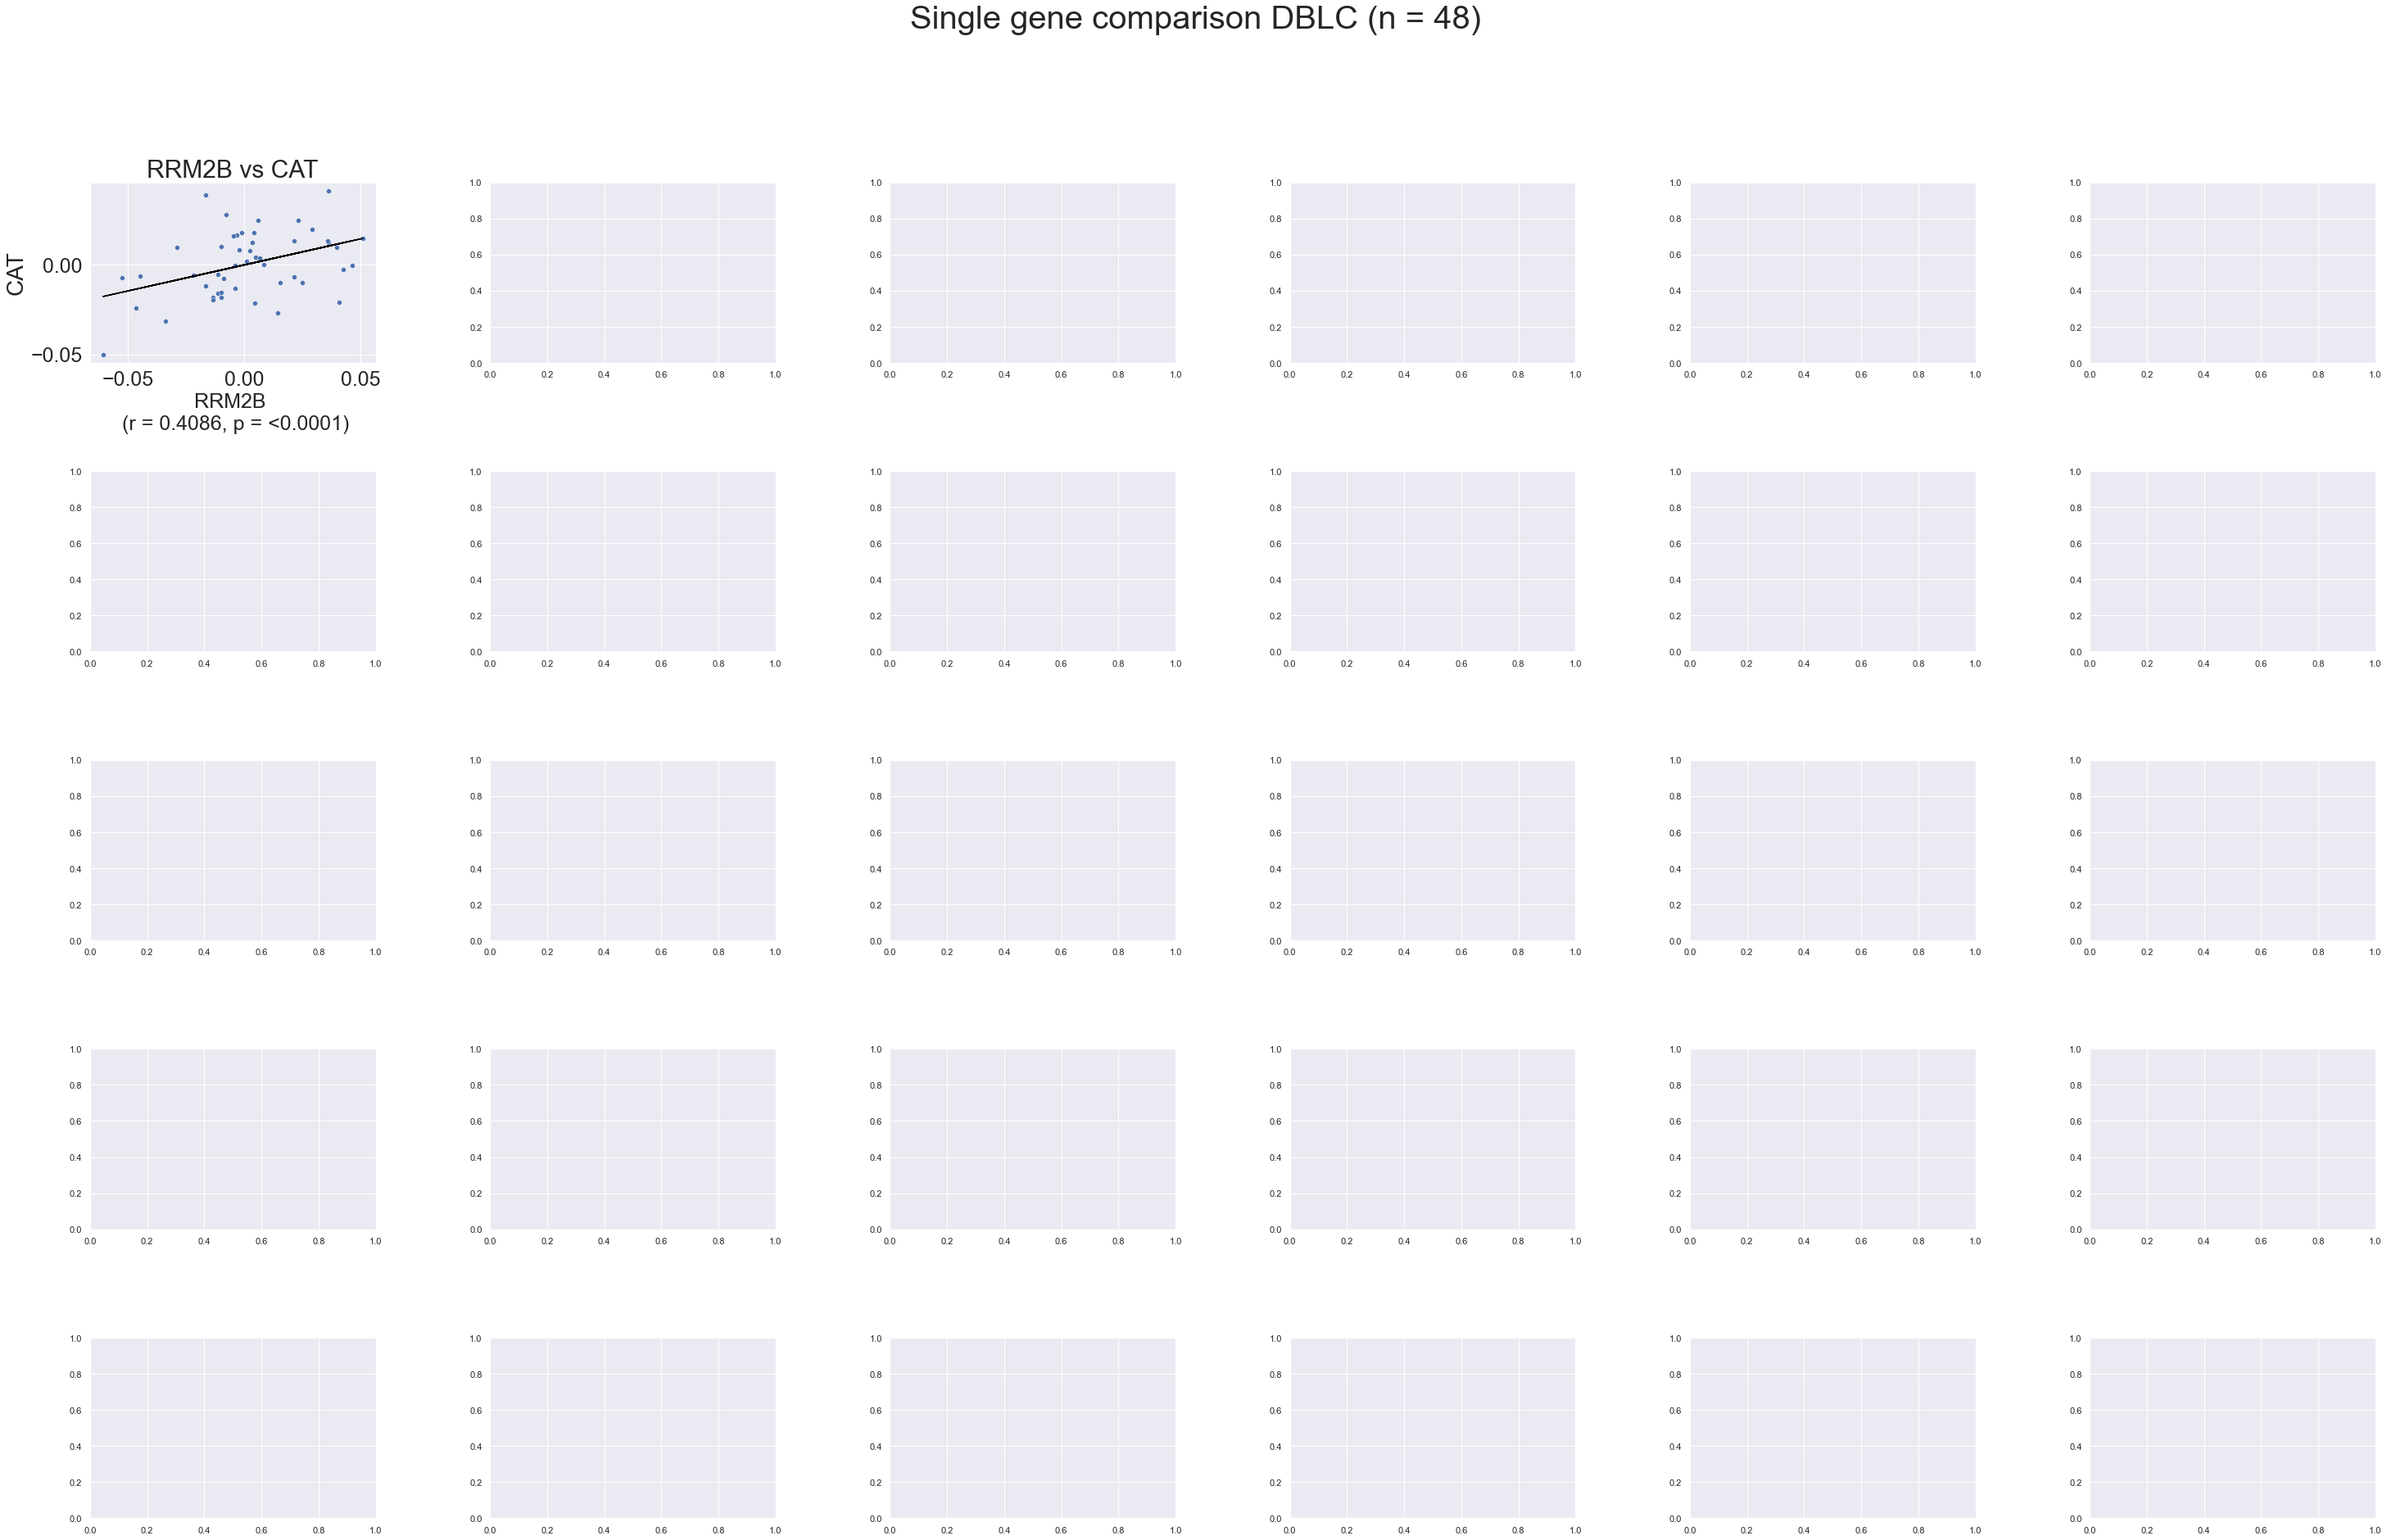

PRDX1
False
[]
False
PRDX6
False
[]
False
GPX2
False
[]
False
GSR
False
[]
False
SLC6A9
False
[]
False
TXN
False
[]
False
SRXN1
False
[]
False
G6PD
False
[]
False
IDH1
False
[]
False
ME1
False
[]
False
PGD
False
[]
False
AKR1B10
False
[]
False
AKR1C1
False
[]
False
ALDH3A1
False
[]
False
CBR1
False
[]
False
EPHX1
False
[]
False
NQO1
False
[]
False
NQO2
False
[]
False
PTGR1
False
[]
False
UGT1A6
False
[]
False
GSTA1
False
[]
False
GSTA2
False
[]
False
GSTA3
False
[]
False
GSTA4
False
[]
False
GSTA5
False
[]
False


/Users/shanghongsim/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/shanghongsim/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


GSTM1
False
[]
False
GSTM2
False
[]
False
GSTM3
False
[]
False
GSTP1
False
[]
False
SKCM
CAT
False
[]
False


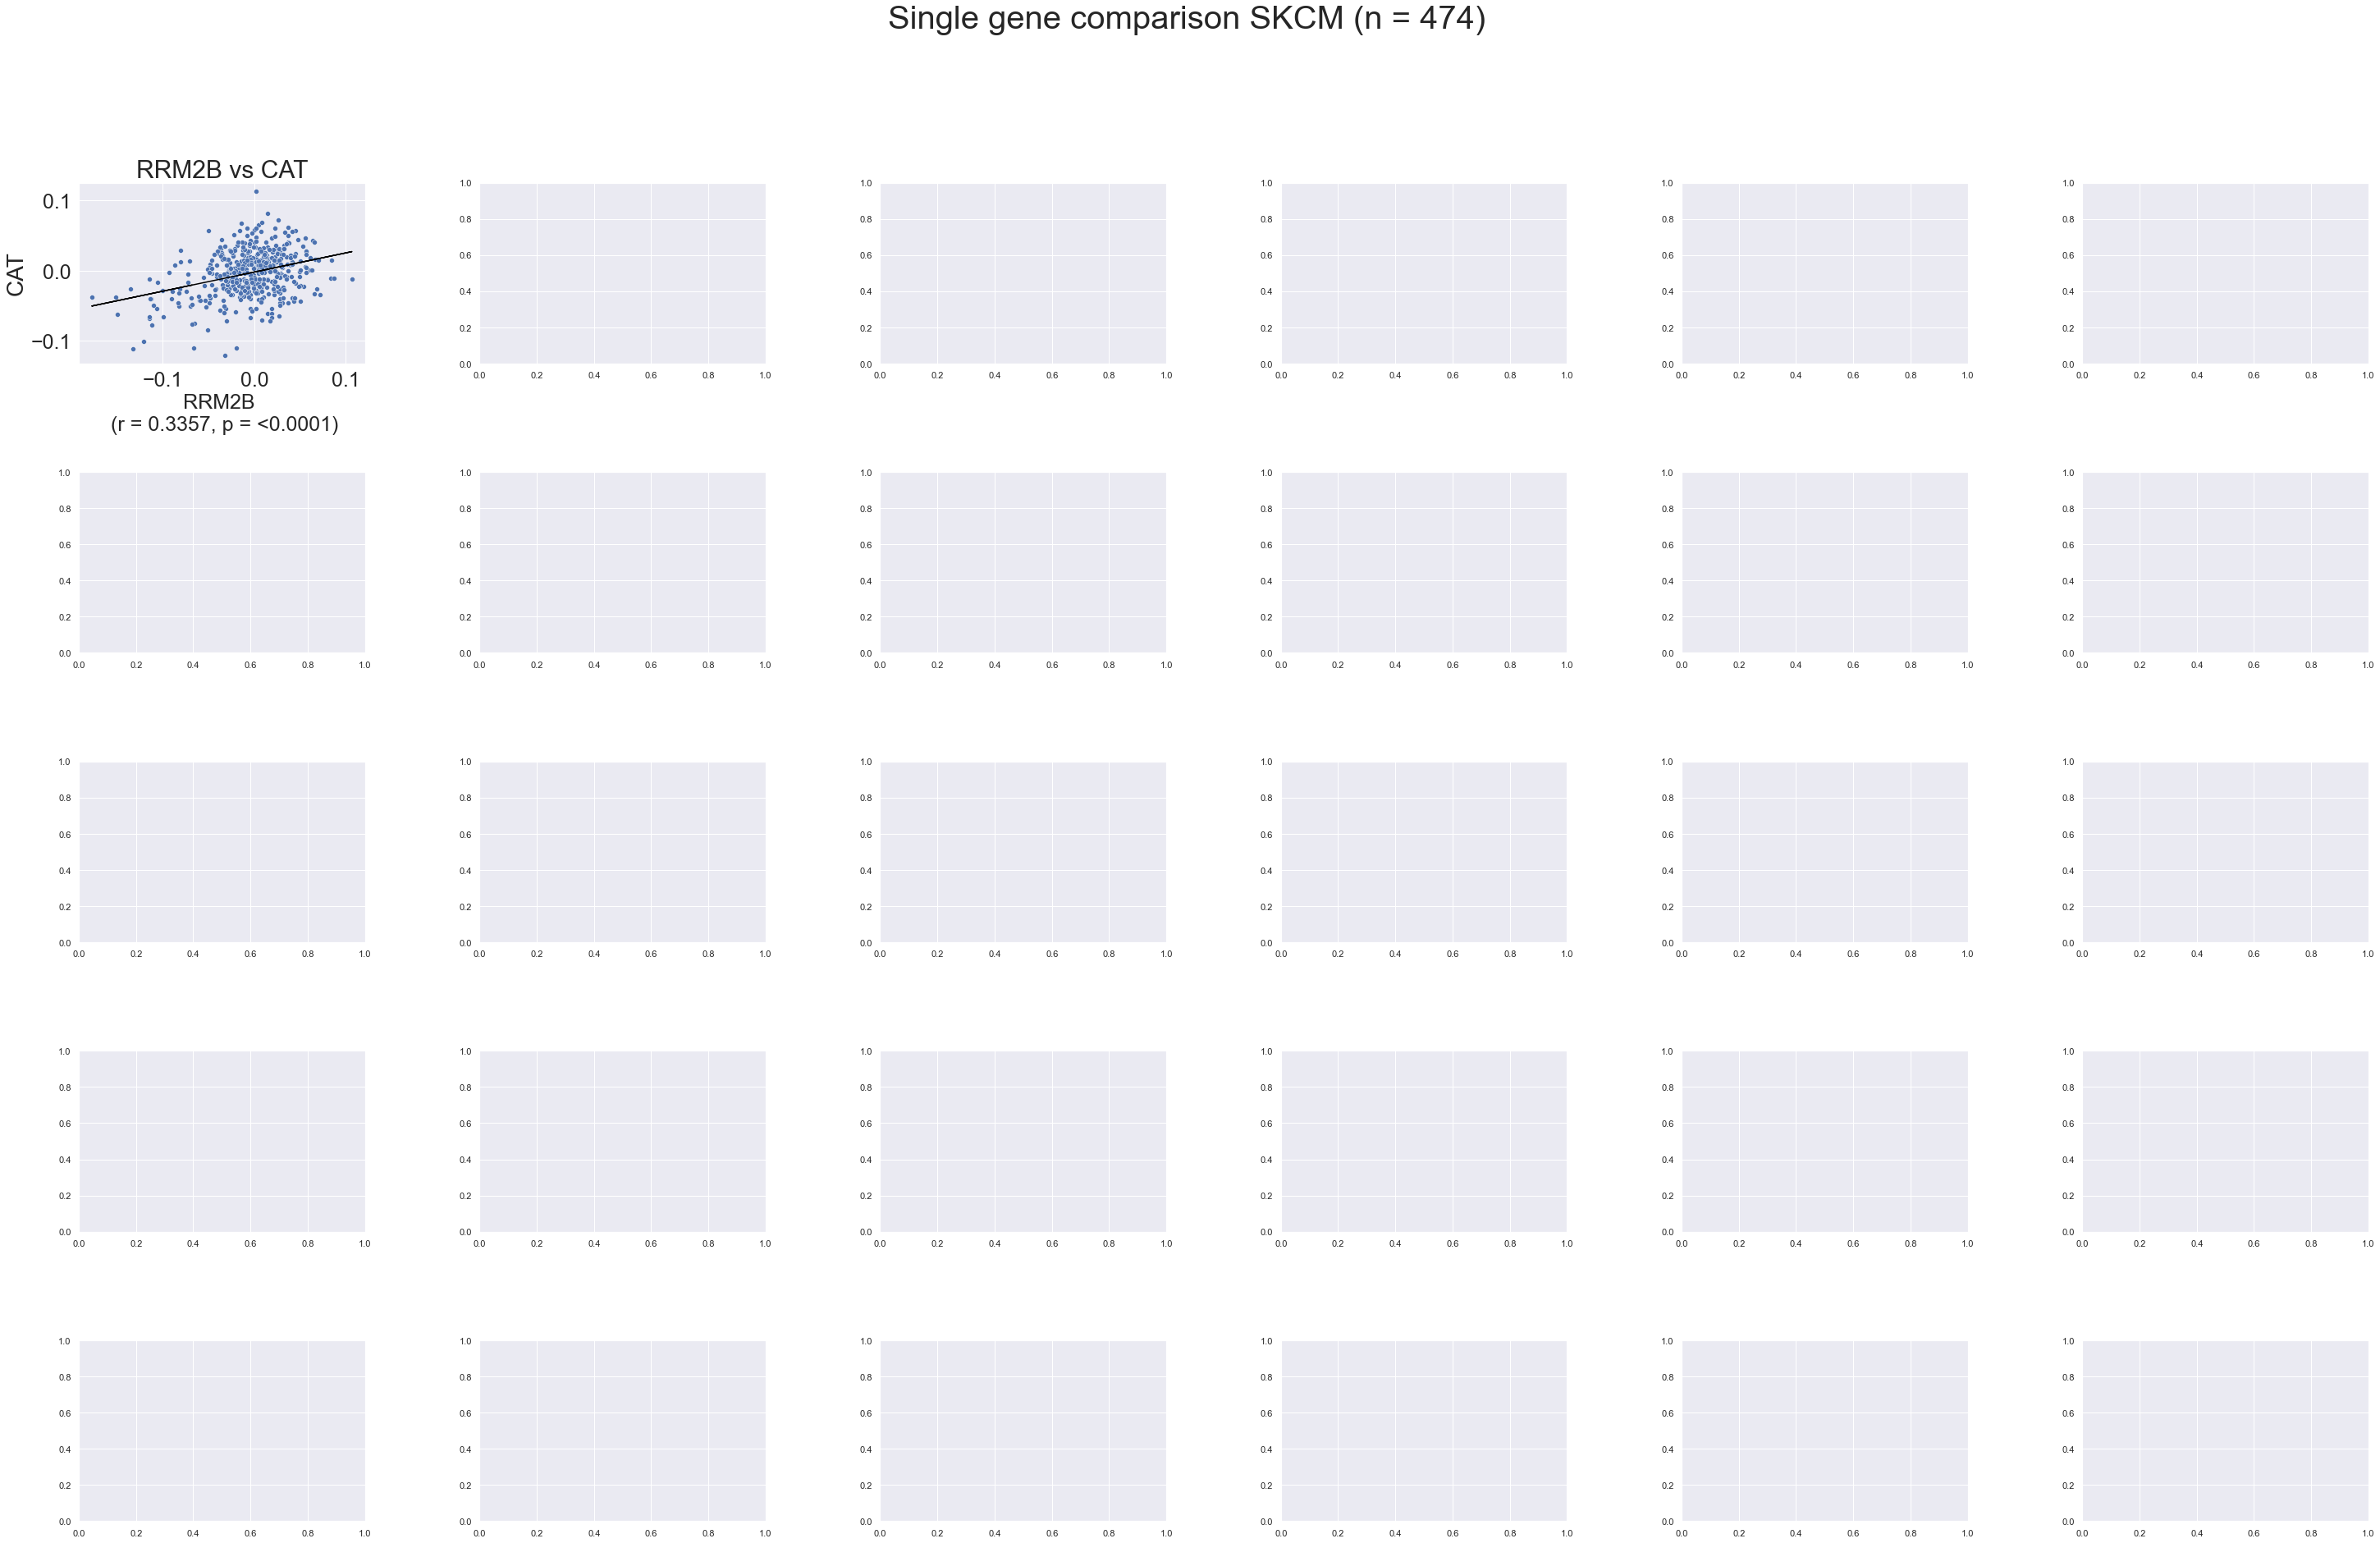

PRDX1
False
[]
False
PRDX6
False
[]
False
GPX2
False
[]
False
GSR
False
[]
False
SLC6A9
False
[]
False
TXN
False
[]
False
SRXN1
False
[]
False
G6PD
False
[]
False
IDH1
False
[]
False
ME1
False
[]
False
PGD
False
[]
False
AKR1B10
False
[]
False
AKR1C1
False
[]
False
ALDH3A1
False
[]
False
CBR1
False
[]
False
EPHX1
False
[]
False
NQO1
False
[]
False
NQO2
False
[]
False
PTGR1
False
[]
False
UGT1A6
False
[]
False
GSTA1
False
[]
False
GSTA2
False
[]
False
GSTA3
False
[]
False
GSTA4
False
[]
False
GSTA5
False
[]
False
GSTM1
False
[]
False
GSTM2
False
[]
False
GSTM3
False
[]
False
GSTP1
False
[]
False
HNSC
CAT
False
[]
False


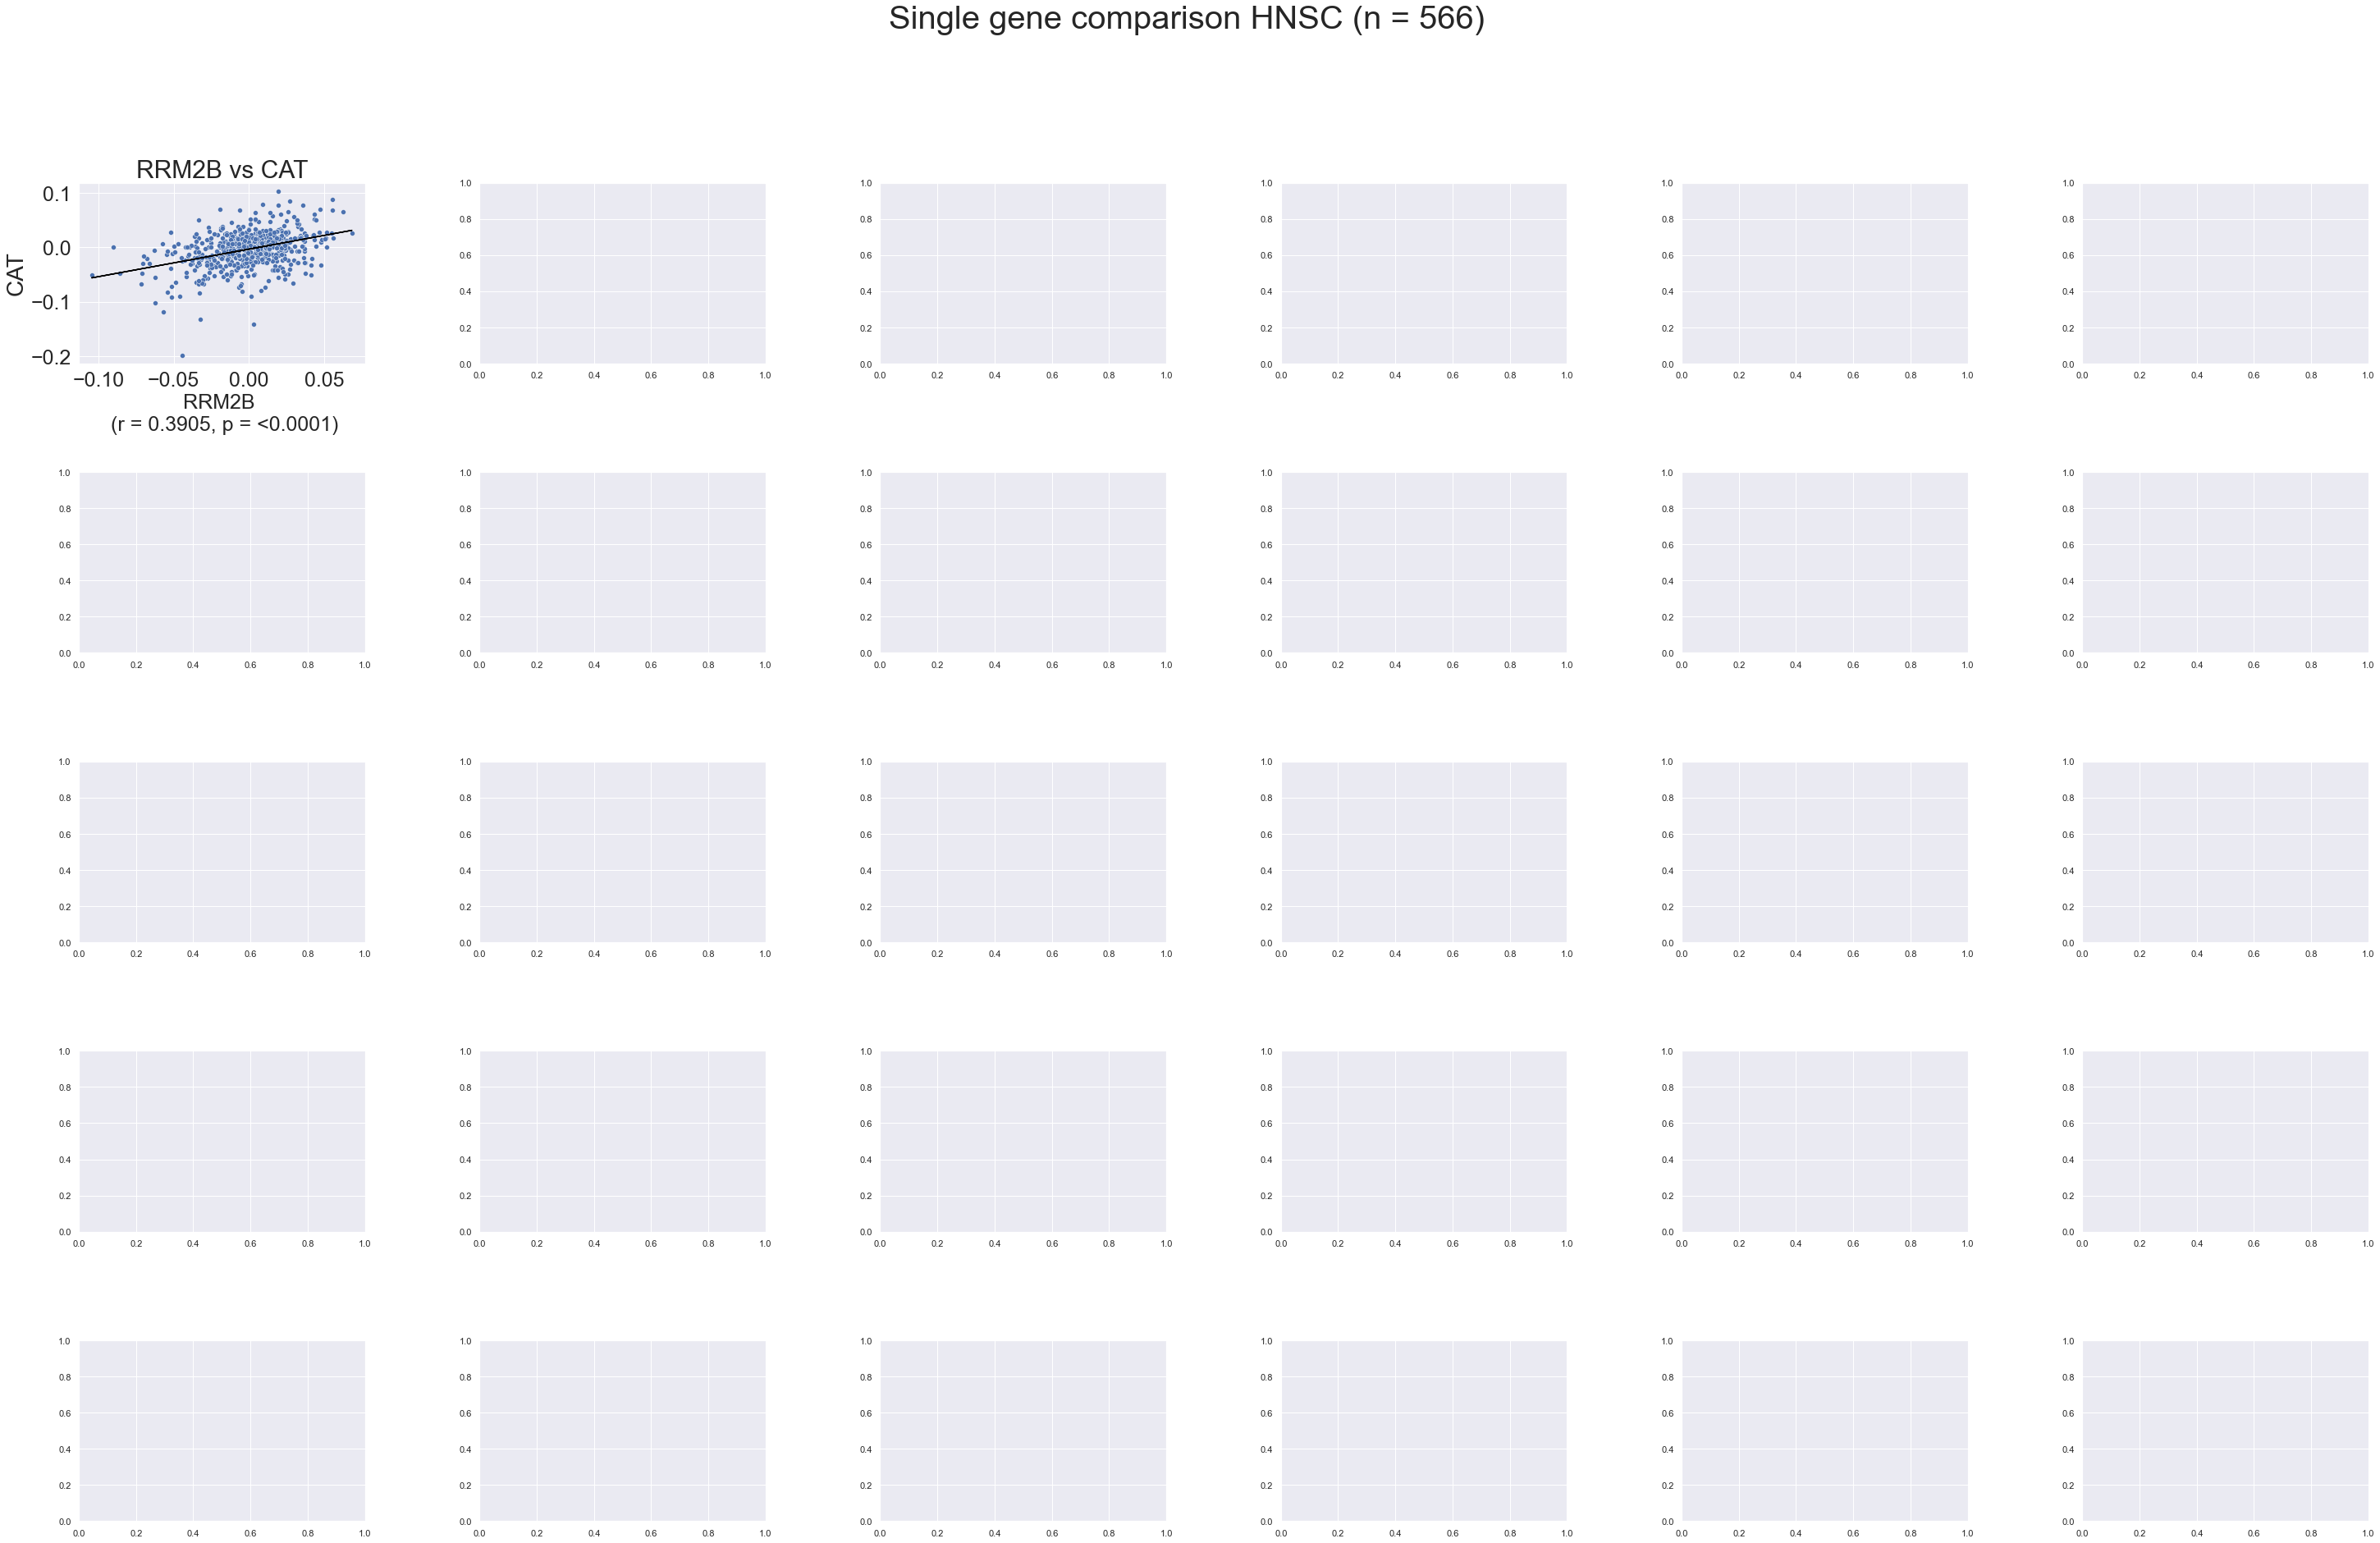

PRDX1
False
[]
False
PRDX6
False
[]
False
GPX2
False
[]
False
GSR
False
[]
False
SLC6A9
False
[]
False
TXN
False
[]
False
SRXN1
False
[]
False
G6PD
False
[]
False
IDH1
False
[]
False
ME1
False
[]
False
PGD
False
[]
False
AKR1B10
False
[]
False
AKR1C1
False
[]
False
ALDH3A1
False
[]
False
CBR1
False
[]
False
EPHX1
False
[]
False
NQO1
False
[]
False
NQO2
False
[]
False
PTGR1
False
[]
False
UGT1A6
False
[]
False
GSTA1
False
[]
False
GSTA2
False
[]
False
GSTA3
False
[]
False
GSTA4
False
[]
False
GSTA5
False
[]
False
GSTM1
False
[]
False
GSTM2
False
[]
False
GSTM3
False
[]
False
GSTP1
False
[]
False
PRAD
CAT
True
['TCGA-EJ-A65B-01', 'TCGA-EJ-A65D-01', 'TCGA-FC-A66V-01', 'TCGA-FC-A6HD-01', 'TCGA-G9-6347-01', 'TCGA-G9-6379-01', 'TCGA-H9-A6BY-01', 'TCGA-HC-A6AL-01', 'TCGA-HC-A6AN-01', 'TCGA-HC-A6AO-01', 'TCGA-HC-A6AP-01', 'TCGA-HC-A6AQ-01', 'TCGA-HC-A6AS-01', 'TCGA-HC-A6HX-01', 'TCGA-HC-A6HY-01', 'TCGA-J4-A67K-01', 'TCGA-J4-A67L-01', 'TCGA-J4-A67M-01', 'TCGA-J4-A67N-01', 'TCGA-J4-A67O-01', 'TC

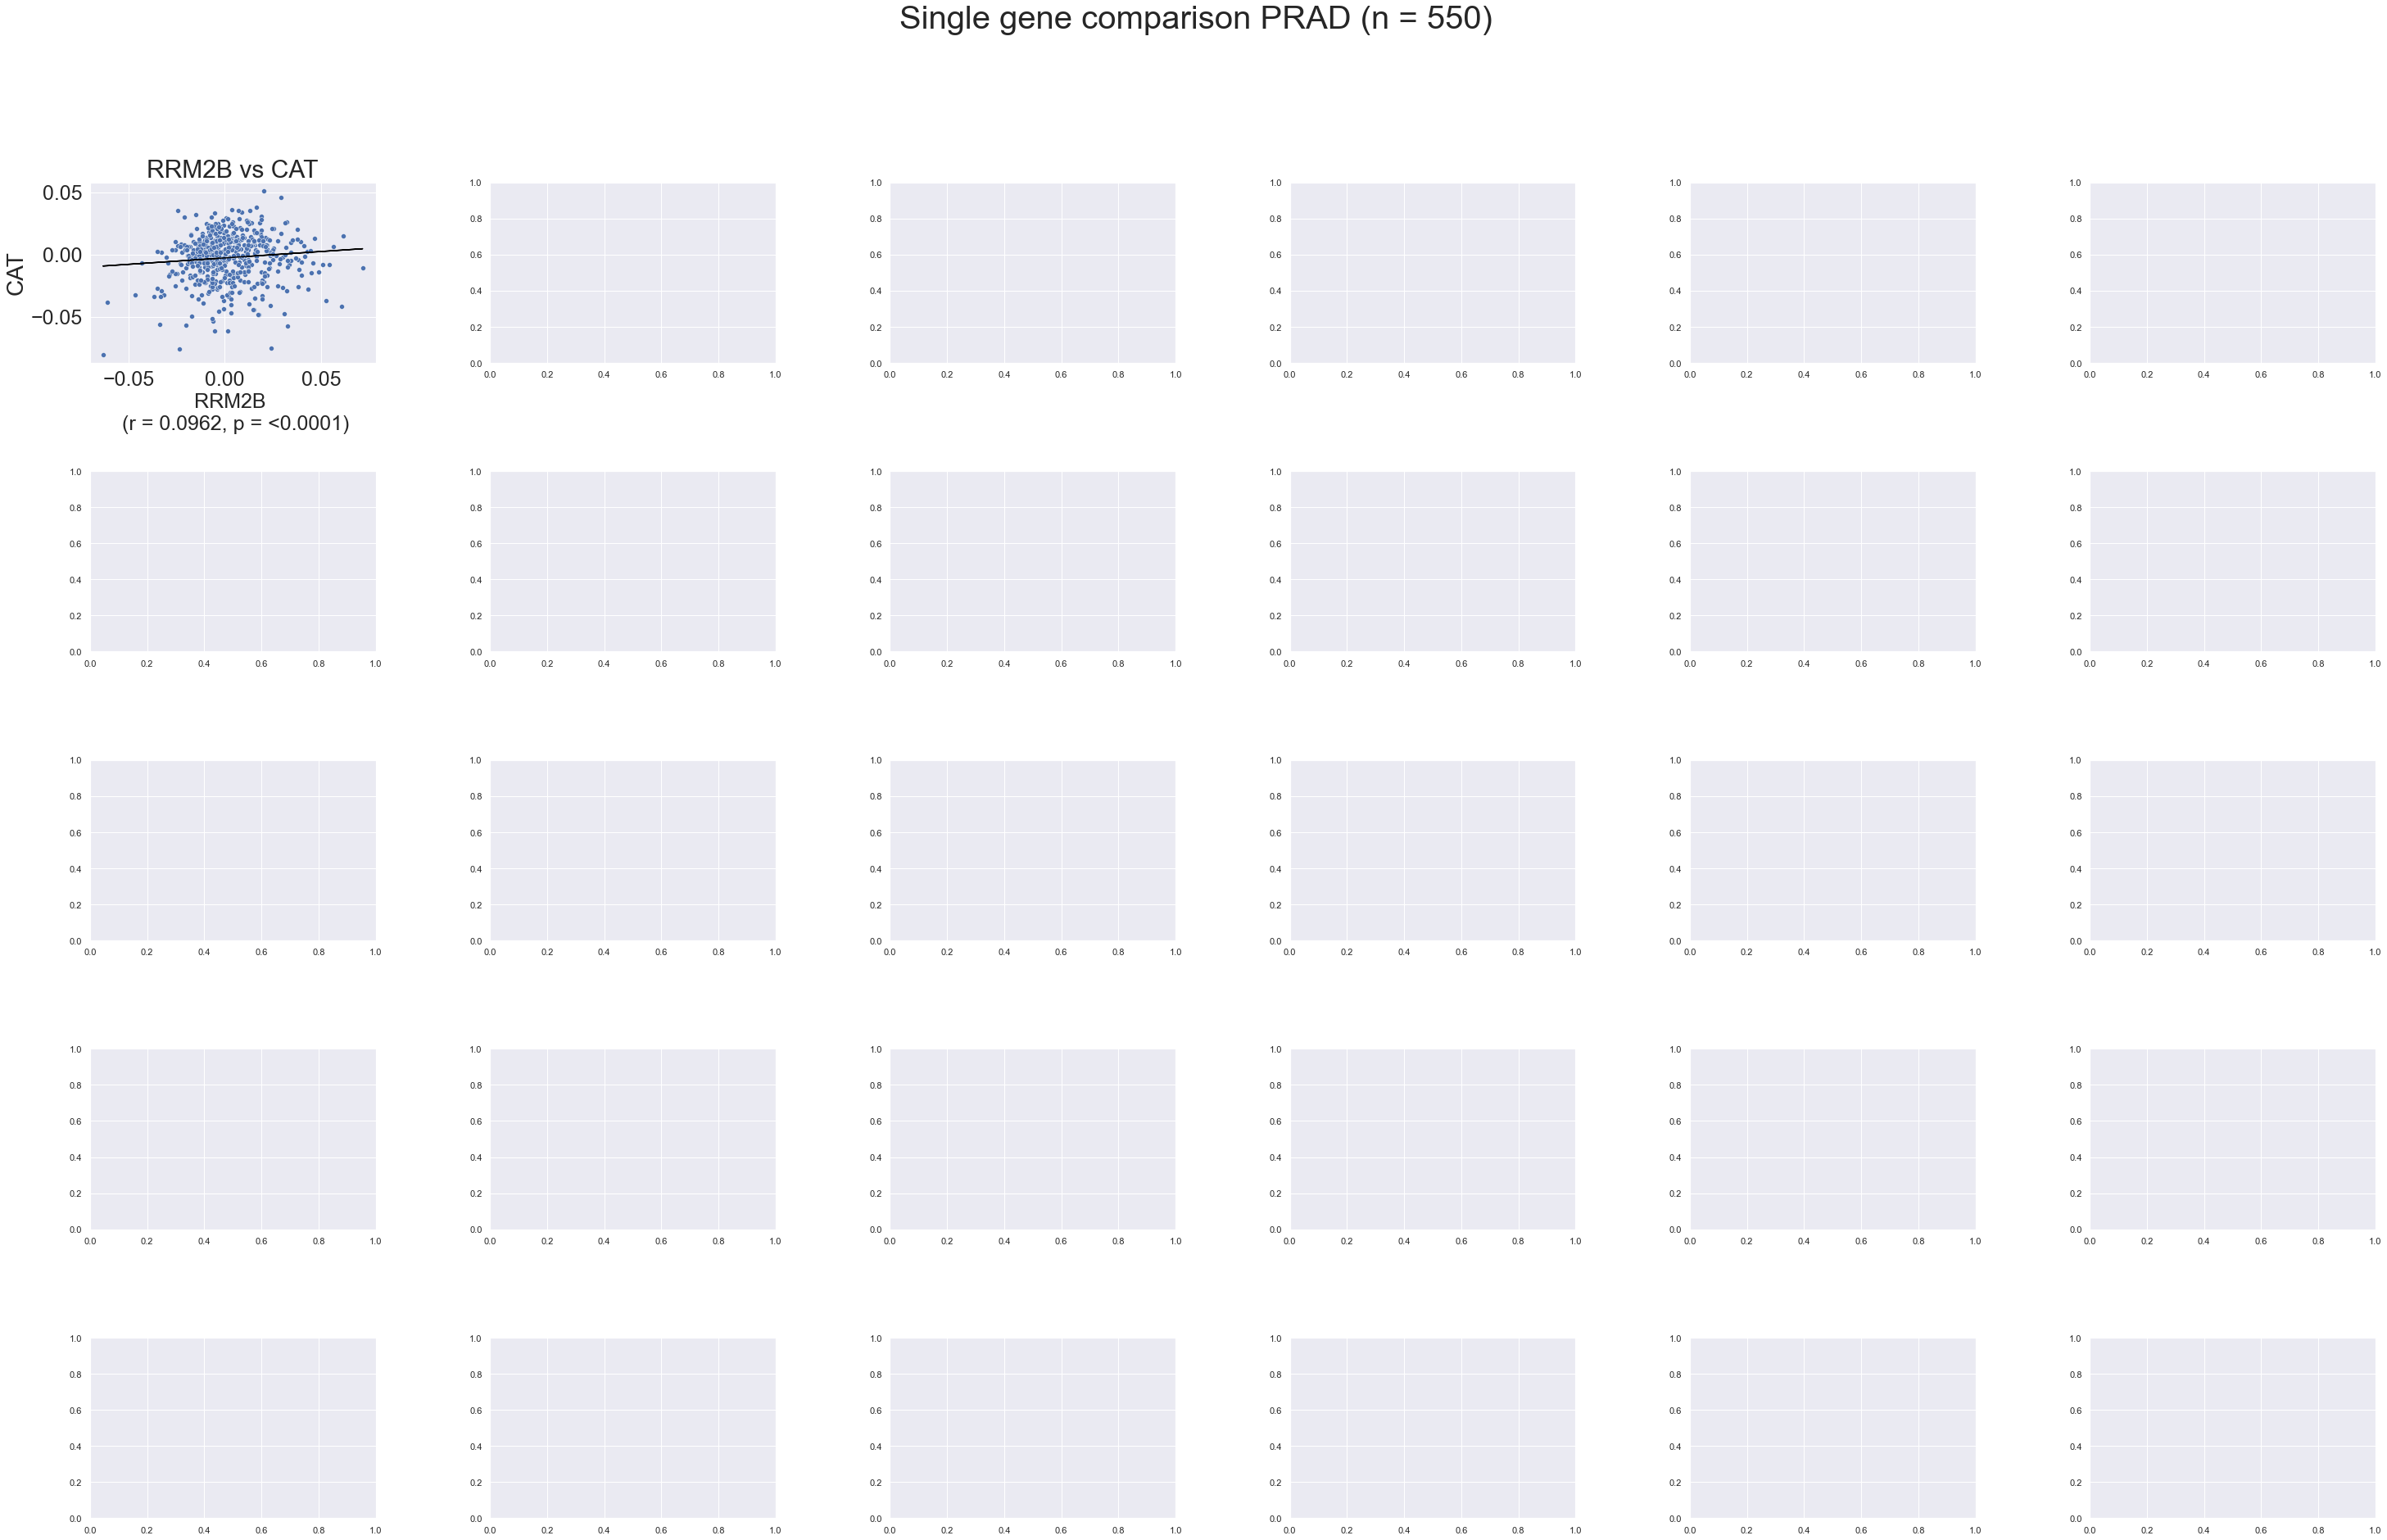

PRDX1
True
['TCGA-EJ-A65B-01', 'TCGA-EJ-A65D-01', 'TCGA-FC-A66V-01', 'TCGA-FC-A6HD-01', 'TCGA-G9-6347-01', 'TCGA-G9-6379-01', 'TCGA-H9-A6BY-01', 'TCGA-HC-A6AL-01', 'TCGA-HC-A6AN-01', 'TCGA-HC-A6AO-01', 'TCGA-HC-A6AP-01', 'TCGA-HC-A6AQ-01', 'TCGA-HC-A6AS-01', 'TCGA-HC-A6HX-01', 'TCGA-HC-A6HY-01', 'TCGA-J4-A67K-01', 'TCGA-J4-A67L-01', 'TCGA-J4-A67M-01', 'TCGA-J4-A67N-01', 'TCGA-J4-A67O-01', 'TCGA-J4-A67Q-01', 'TCGA-J4-A67R-01', 'TCGA-J4-A67S-01', 'TCGA-J4-A6M7-01', 'TCGA-KK-A6E3-01', 'TCGA-KK-A6E4-01', 'TCGA-KK-A6E7-01', 'TCGA-KK-A6E8-01', 'TCGA-QU-A6IL-01', 'TCGA-QU-A6IM-01', 'TCGA-QU-A6IN-01', 'TCGA-QU-A6IO-01', 'TCGA-QU-A6IP-01']
False
PRDX6
True
['TCGA-EJ-A65B-01', 'TCGA-EJ-A65D-01', 'TCGA-FC-A66V-01', 'TCGA-FC-A6HD-01', 'TCGA-G9-6347-01', 'TCGA-G9-6379-01', 'TCGA-H9-A6BY-01', 'TCGA-HC-A6AL-01', 'TCGA-HC-A6AN-01', 'TCGA-HC-A6AO-01', 'TCGA-HC-A6AP-01', 'TCGA-HC-A6AQ-01', 'TCGA-HC-A6AS-01', 'TCGA-HC-A6HX-01', 'TCGA-HC-A6HY-01', 'TCGA-J4-A67K-01', 'TCGA-J4-A67L-01', 'TCGA-J4-A67M-01', '

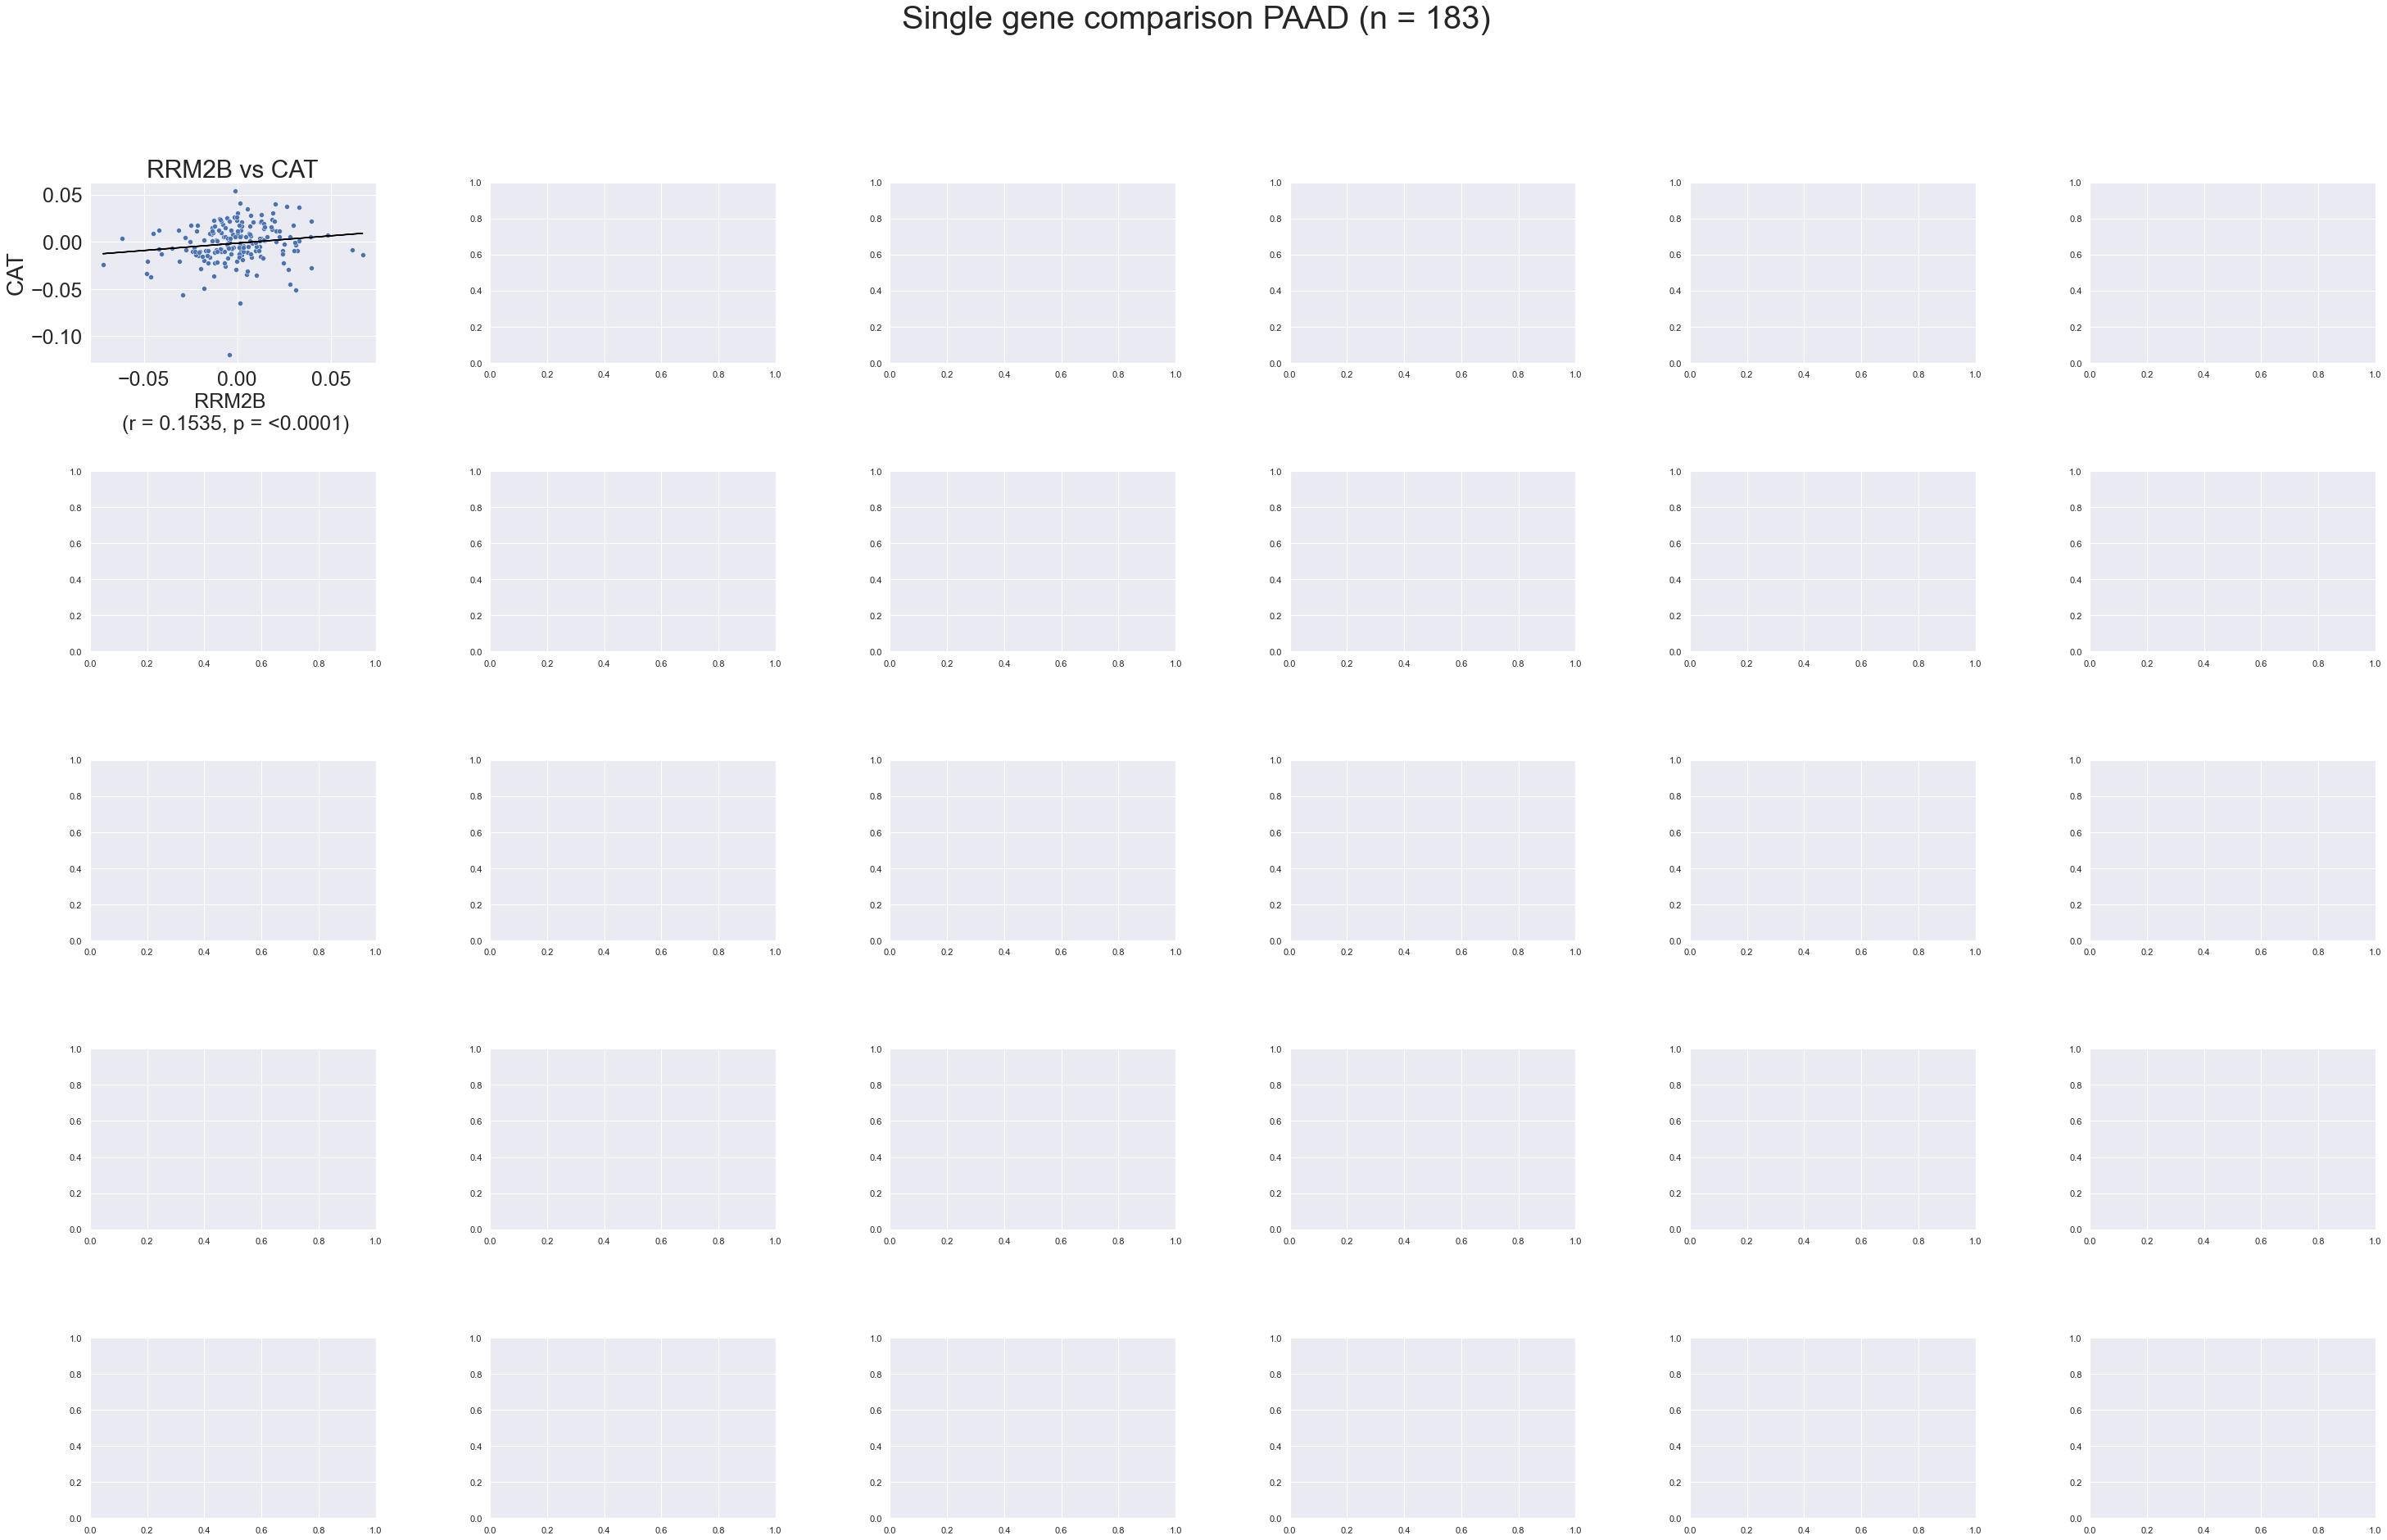

PRDX1
False
[]
False
PRDX6
False
[]
False
GPX2
False
[]
False
GSR
False
[]
False
SLC6A9
False
[]
False
TXN
False
[]
False
SRXN1
False
[]
False
G6PD
False
[]
False
IDH1
False
[]
False
ME1
False
[]
False
PGD
False
[]
False
AKR1B10
False
[]
False
AKR1C1
False
[]
False
ALDH3A1
False
[]
False
CBR1
False
[]
False
EPHX1
False
[]
False
NQO1
False
[]
False
NQO2
False
[]
False
PTGR1
False
[]
False
UGT1A6
False
[]
False
GSTA1
False
[]
False
GSTA2
False
[]
False
GSTA3
False
[]
False
GSTA4
False
[]
False
GSTA5
False
[]
False
GSTM1
False
[]
False
GSTM2
False
[]
False
GSTM3
False
[]
False
GSTP1
False
[]
False
SARC
CAT
False
[]
False


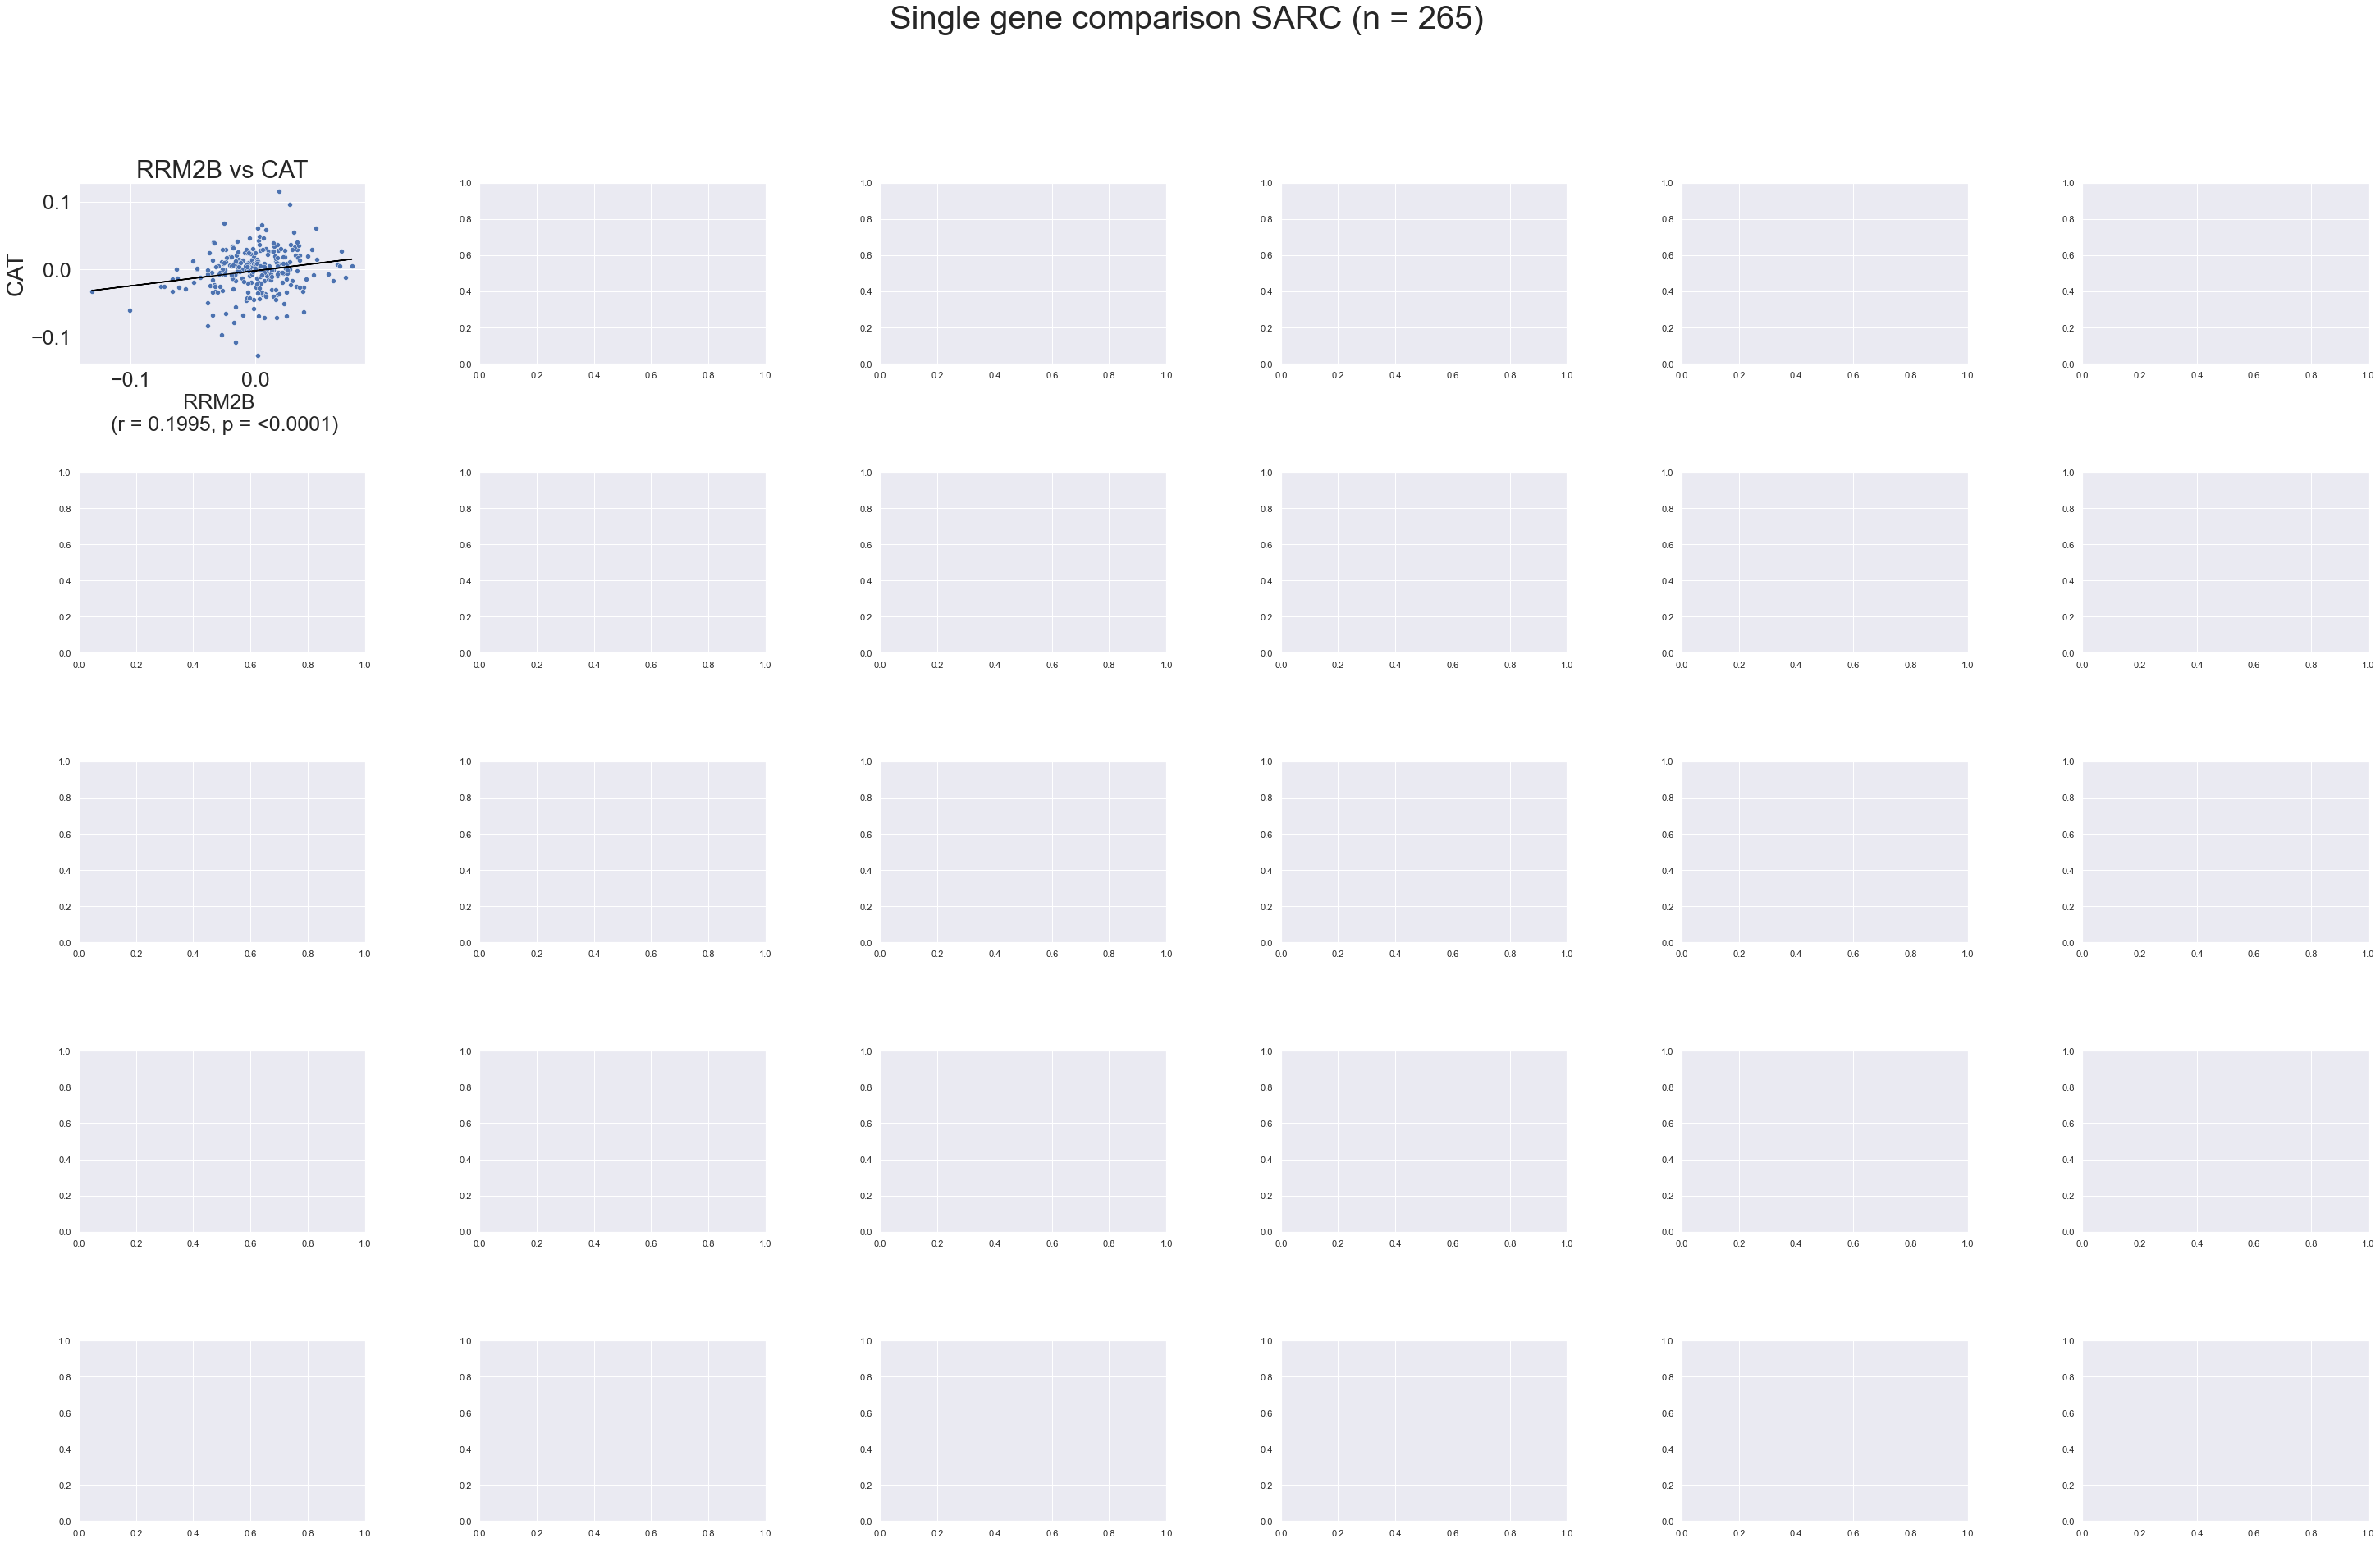

PRDX1
False
[]
False
PRDX6
False
[]
False
GPX2
False
[]
False
GSR
False
[]
False
SLC6A9
False
[]
False
TXN
False
[]
False
SRXN1
False
[]
False
G6PD
False
[]
False
IDH1
False
[]
False
ME1
False
[]
False
PGD
False
[]
False
AKR1B10
False
[]
False
AKR1C1
False
[]
False
ALDH3A1
False
[]
False
CBR1
False
[]
False
EPHX1
False
[]
False
NQO1
False
[]
False
NQO2
False
[]
False
PTGR1
False
[]
False
UGT1A6
False
[]
False
GSTA1
False
[]
False
GSTA2
False
[]
False
GSTA3
False
[]
False
GSTA4
False
[]
False
GSTA5
False
[]
False
GSTM1
False
[]
False
GSTM2
False
[]
False
GSTM3
False
[]
False
GSTP1
False
[]
False
BRCA
CAT
False
[]
False


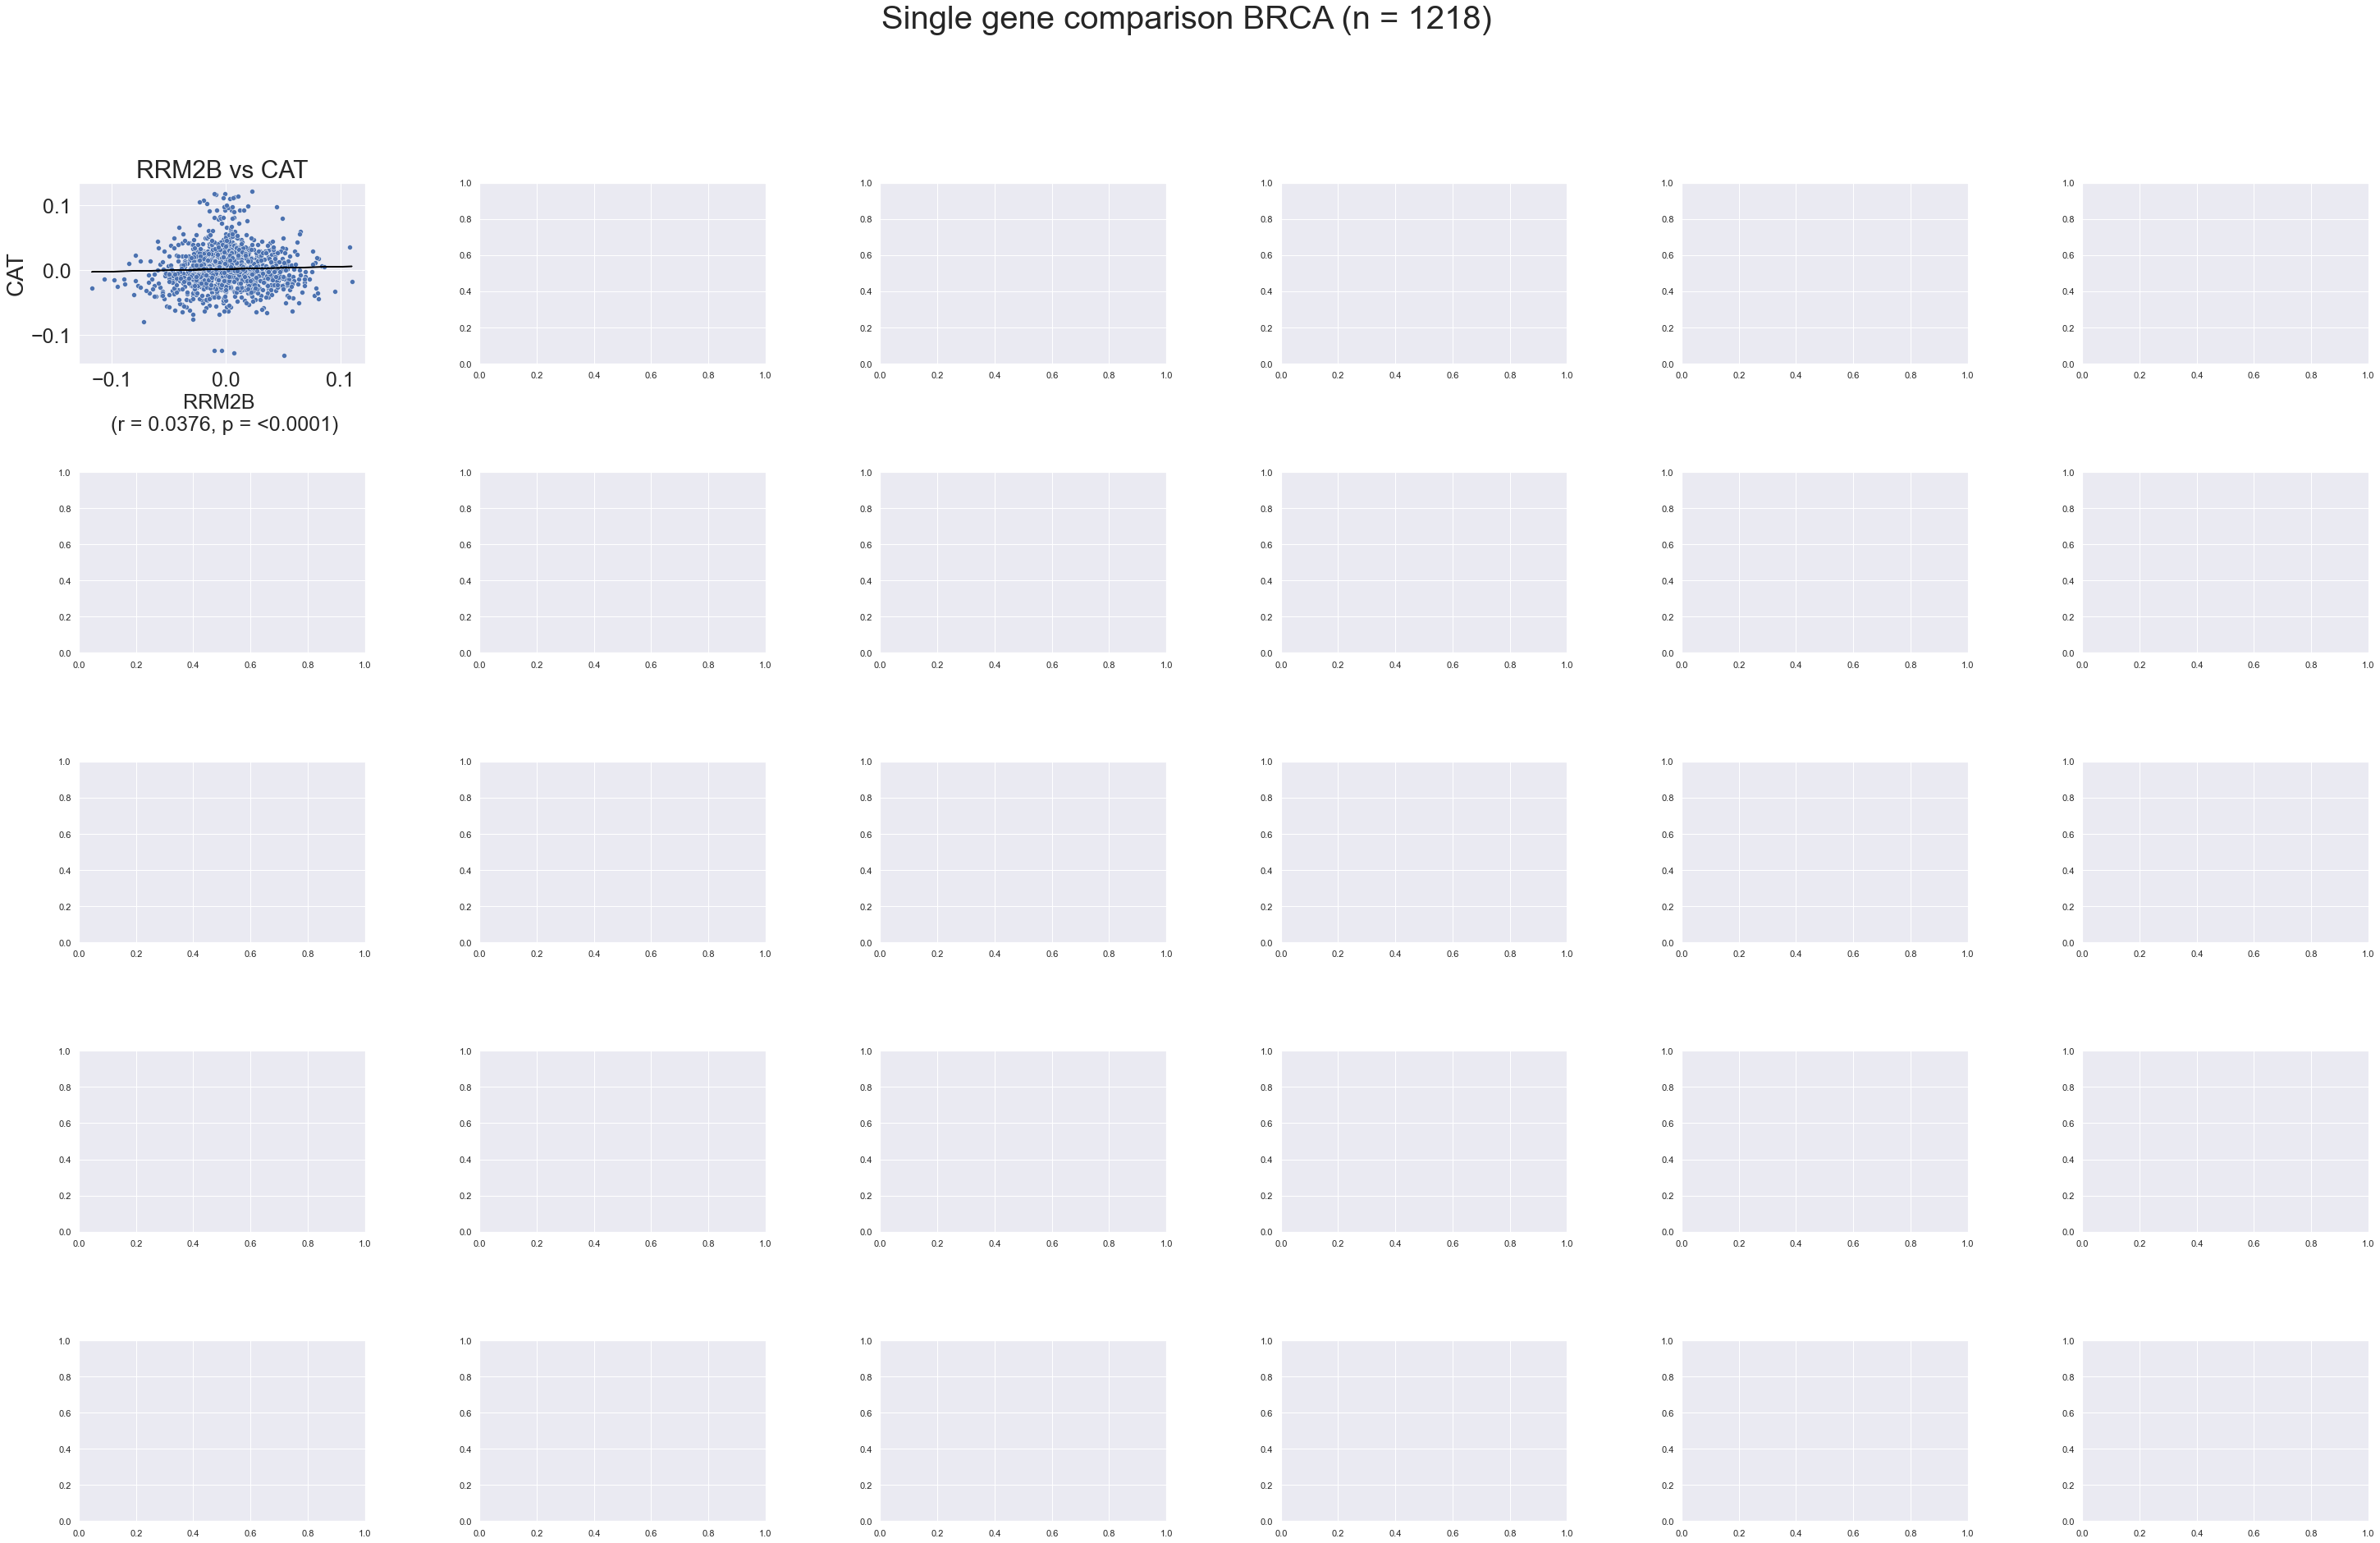

PRDX1
False
[]
False
PRDX6
False
[]
False
GPX2
False
[]
False
GSR
False
[]
False
SLC6A9
False
[]
False
TXN
False
[]
False
SRXN1
False
[]
False
G6PD
False
[]
False
IDH1
False
[]
False
ME1
False
[]
False
PGD
False
[]
False
AKR1B10
False
[]
False
AKR1C1
False
[]
False
ALDH3A1
False
[]
False
CBR1
False
[]
False
EPHX1
False
[]
False
NQO1
False
[]
False
NQO2
False
[]
False
PTGR1
False
[]
False
UGT1A6
False
[]
False
GSTA1
False
[]
False
GSTA2
False
[]
False
GSTA3
False
[]
False
GSTA4
False
[]
False
GSTA5
False
[]
False
GSTM1
False
[]
False
GSTM2
False
[]
False
GSTM3
False
[]
False
GSTP1
False
[]
False
UCS
CAT
False
[]
False


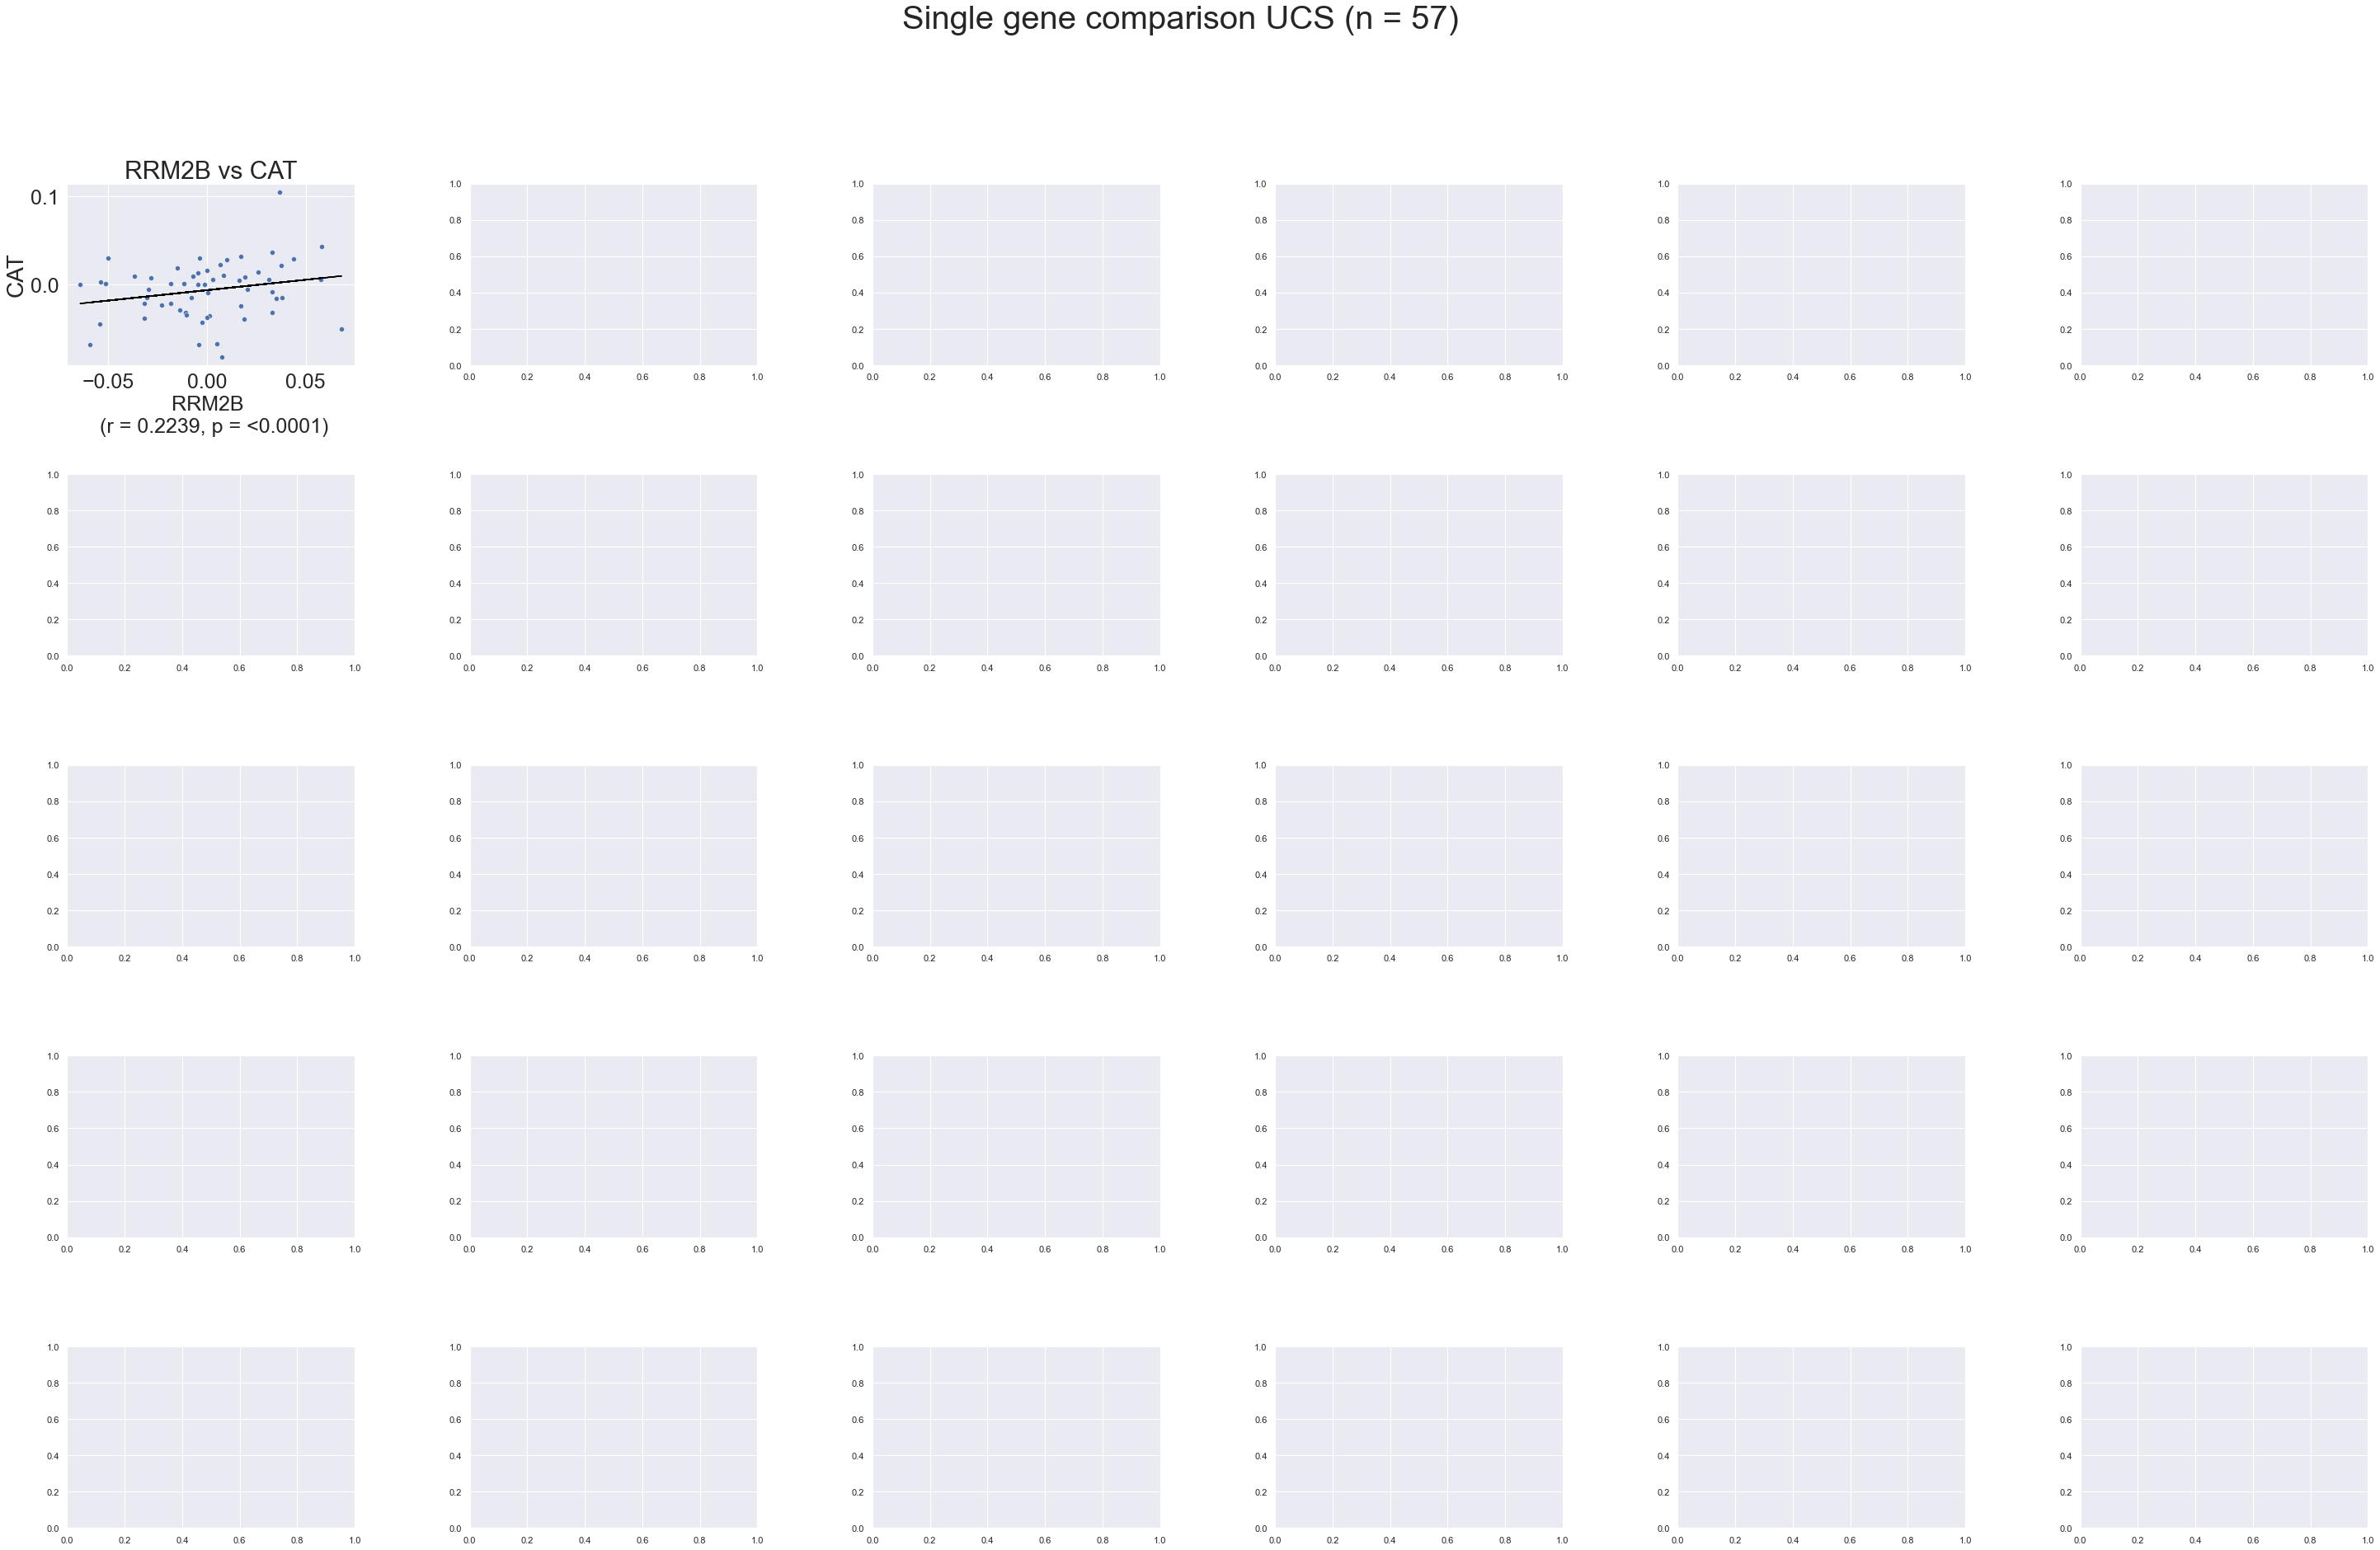

PRDX1
False
[]
False
PRDX6
False
[]
False
GPX2
False
[]
False
GSR
False
[]
False
SLC6A9
False
[]
False
TXN
False
[]
False
SRXN1
False
[]
False
G6PD
False
[]
False
IDH1
False
[]
False
ME1
False
[]
False
PGD
False
[]
False
AKR1B10
False
[]
False
AKR1C1
False
[]
False
ALDH3A1
False
[]
False
CBR1
False
[]
False
EPHX1
False
[]
False
NQO1
False
[]
False
NQO2
False
[]
False
PTGR1
False
[]
False
UGT1A6
False
[]
False
GSTA1
False
[]
False
GSTA2
False
[]
False
GSTA3
False
[]
False
GSTA4
False
[]
False
GSTA5
False
[]
False
GSTM1
False
[]
False
GSTM2
False
[]
False
GSTM3
False
[]
False
GSTP1
False
[]
False
ESCA
CAT
True
['TCGA-2H-A9GF-01', 'TCGA-2H-A9GG-01', 'TCGA-2H-A9GH-01', 'TCGA-2H-A9GI-01', 'TCGA-2H-A9GJ-01', 'TCGA-2H-A9GK-01', 'TCGA-2H-A9GL-01', 'TCGA-2H-A9GM-01', 'TCGA-2H-A9GN-01', 'TCGA-2H-A9GO-01', 'TCGA-2H-A9GQ-01', 'TCGA-2H-A9GR-01', 'TCGA-IC-A6RE-01', 'TCGA-IC-A6RE-11', 'TCGA-IG-A3I8-01', 'TCGA-IG-A3I8-11', 'TCGA-IG-A3QL-01', 'TCGA-IG-A3Y9-01', 'TCGA-IG-A3YA-01', 'TCGA-IG-A3YB-01', 'TC

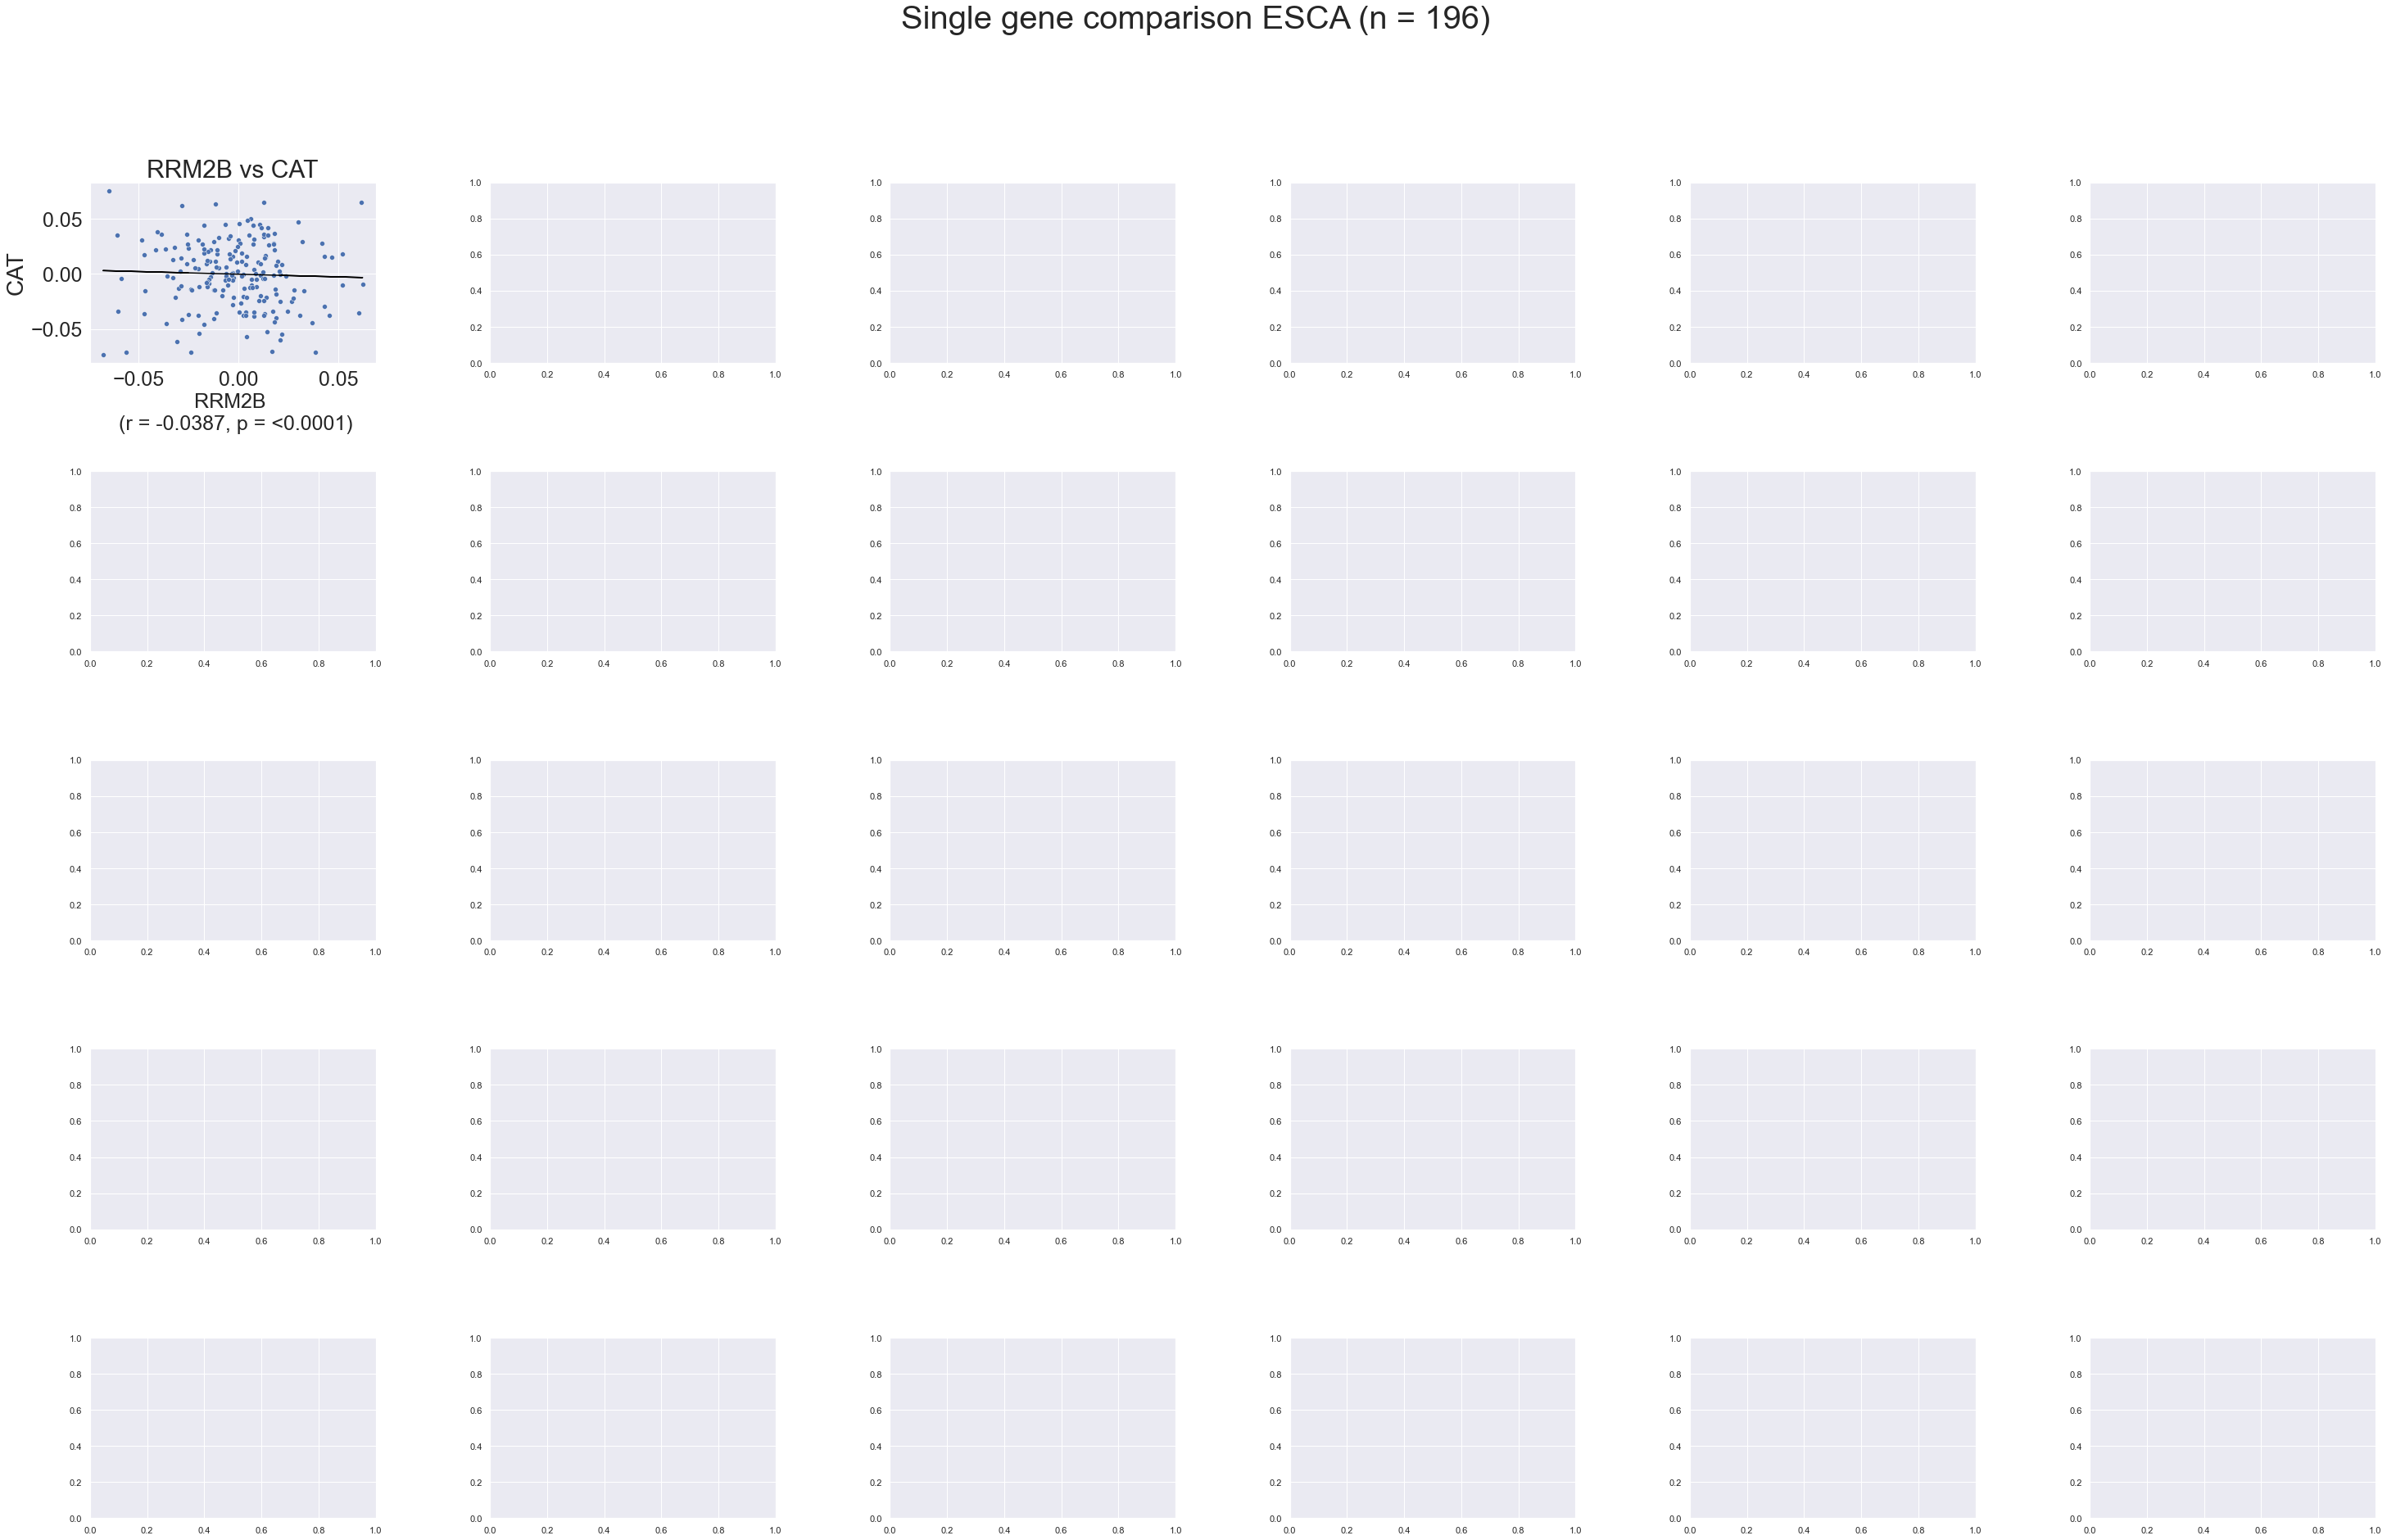

PRDX1
True
['TCGA-2H-A9GF-01', 'TCGA-2H-A9GG-01', 'TCGA-2H-A9GH-01', 'TCGA-2H-A9GI-01', 'TCGA-2H-A9GJ-01', 'TCGA-2H-A9GK-01', 'TCGA-2H-A9GL-01', 'TCGA-2H-A9GM-01', 'TCGA-2H-A9GN-01', 'TCGA-2H-A9GO-01', 'TCGA-2H-A9GQ-01', 'TCGA-2H-A9GR-01', 'TCGA-IC-A6RE-01', 'TCGA-IC-A6RE-11', 'TCGA-IG-A3I8-01', 'TCGA-IG-A3I8-11', 'TCGA-IG-A3QL-01', 'TCGA-IG-A3Y9-01', 'TCGA-IG-A3YA-01', 'TCGA-IG-A3YB-01', 'TCGA-IG-A3YC-01', 'TCGA-IG-A4P3-01', 'TCGA-IG-A4QS-01', 'TCGA-IG-A4QT-01', 'TCGA-IG-A50L-01', 'TCGA-IG-A51D-01', 'TCGA-IG-A5B8-01', 'TCGA-IG-A5S3-01', 'TCGA-IG-A625-01', 'TCGA-IG-A6QS-01', 'TCGA-IG-A7DP-01', 'TCGA-IG-A8O2-01', 'TCGA-IG-A97H-01', 'TCGA-IG-A97I-01', 'TCGA-JY-A6F8-01', 'TCGA-JY-A6FA-01', 'TCGA-JY-A6FB-01', 'TCGA-JY-A6FD-01', 'TCGA-JY-A6FE-01', 'TCGA-JY-A6FG-01', 'TCGA-JY-A6FH-01', 'TCGA-JY-A938-01', 'TCGA-JY-A939-01', 'TCGA-JY-A93C-01', 'TCGA-JY-A93D-01', 'TCGA-JY-A93E-01', 'TCGA-JY-A93F-01', 'TCGA-KH-A6WC-01', 'TCGA-L5-A43C-01', 'TCGA-L5-A43C-11', 'TCGA-L5-A43E-01', 'TCGA-L5-A43H-01', 

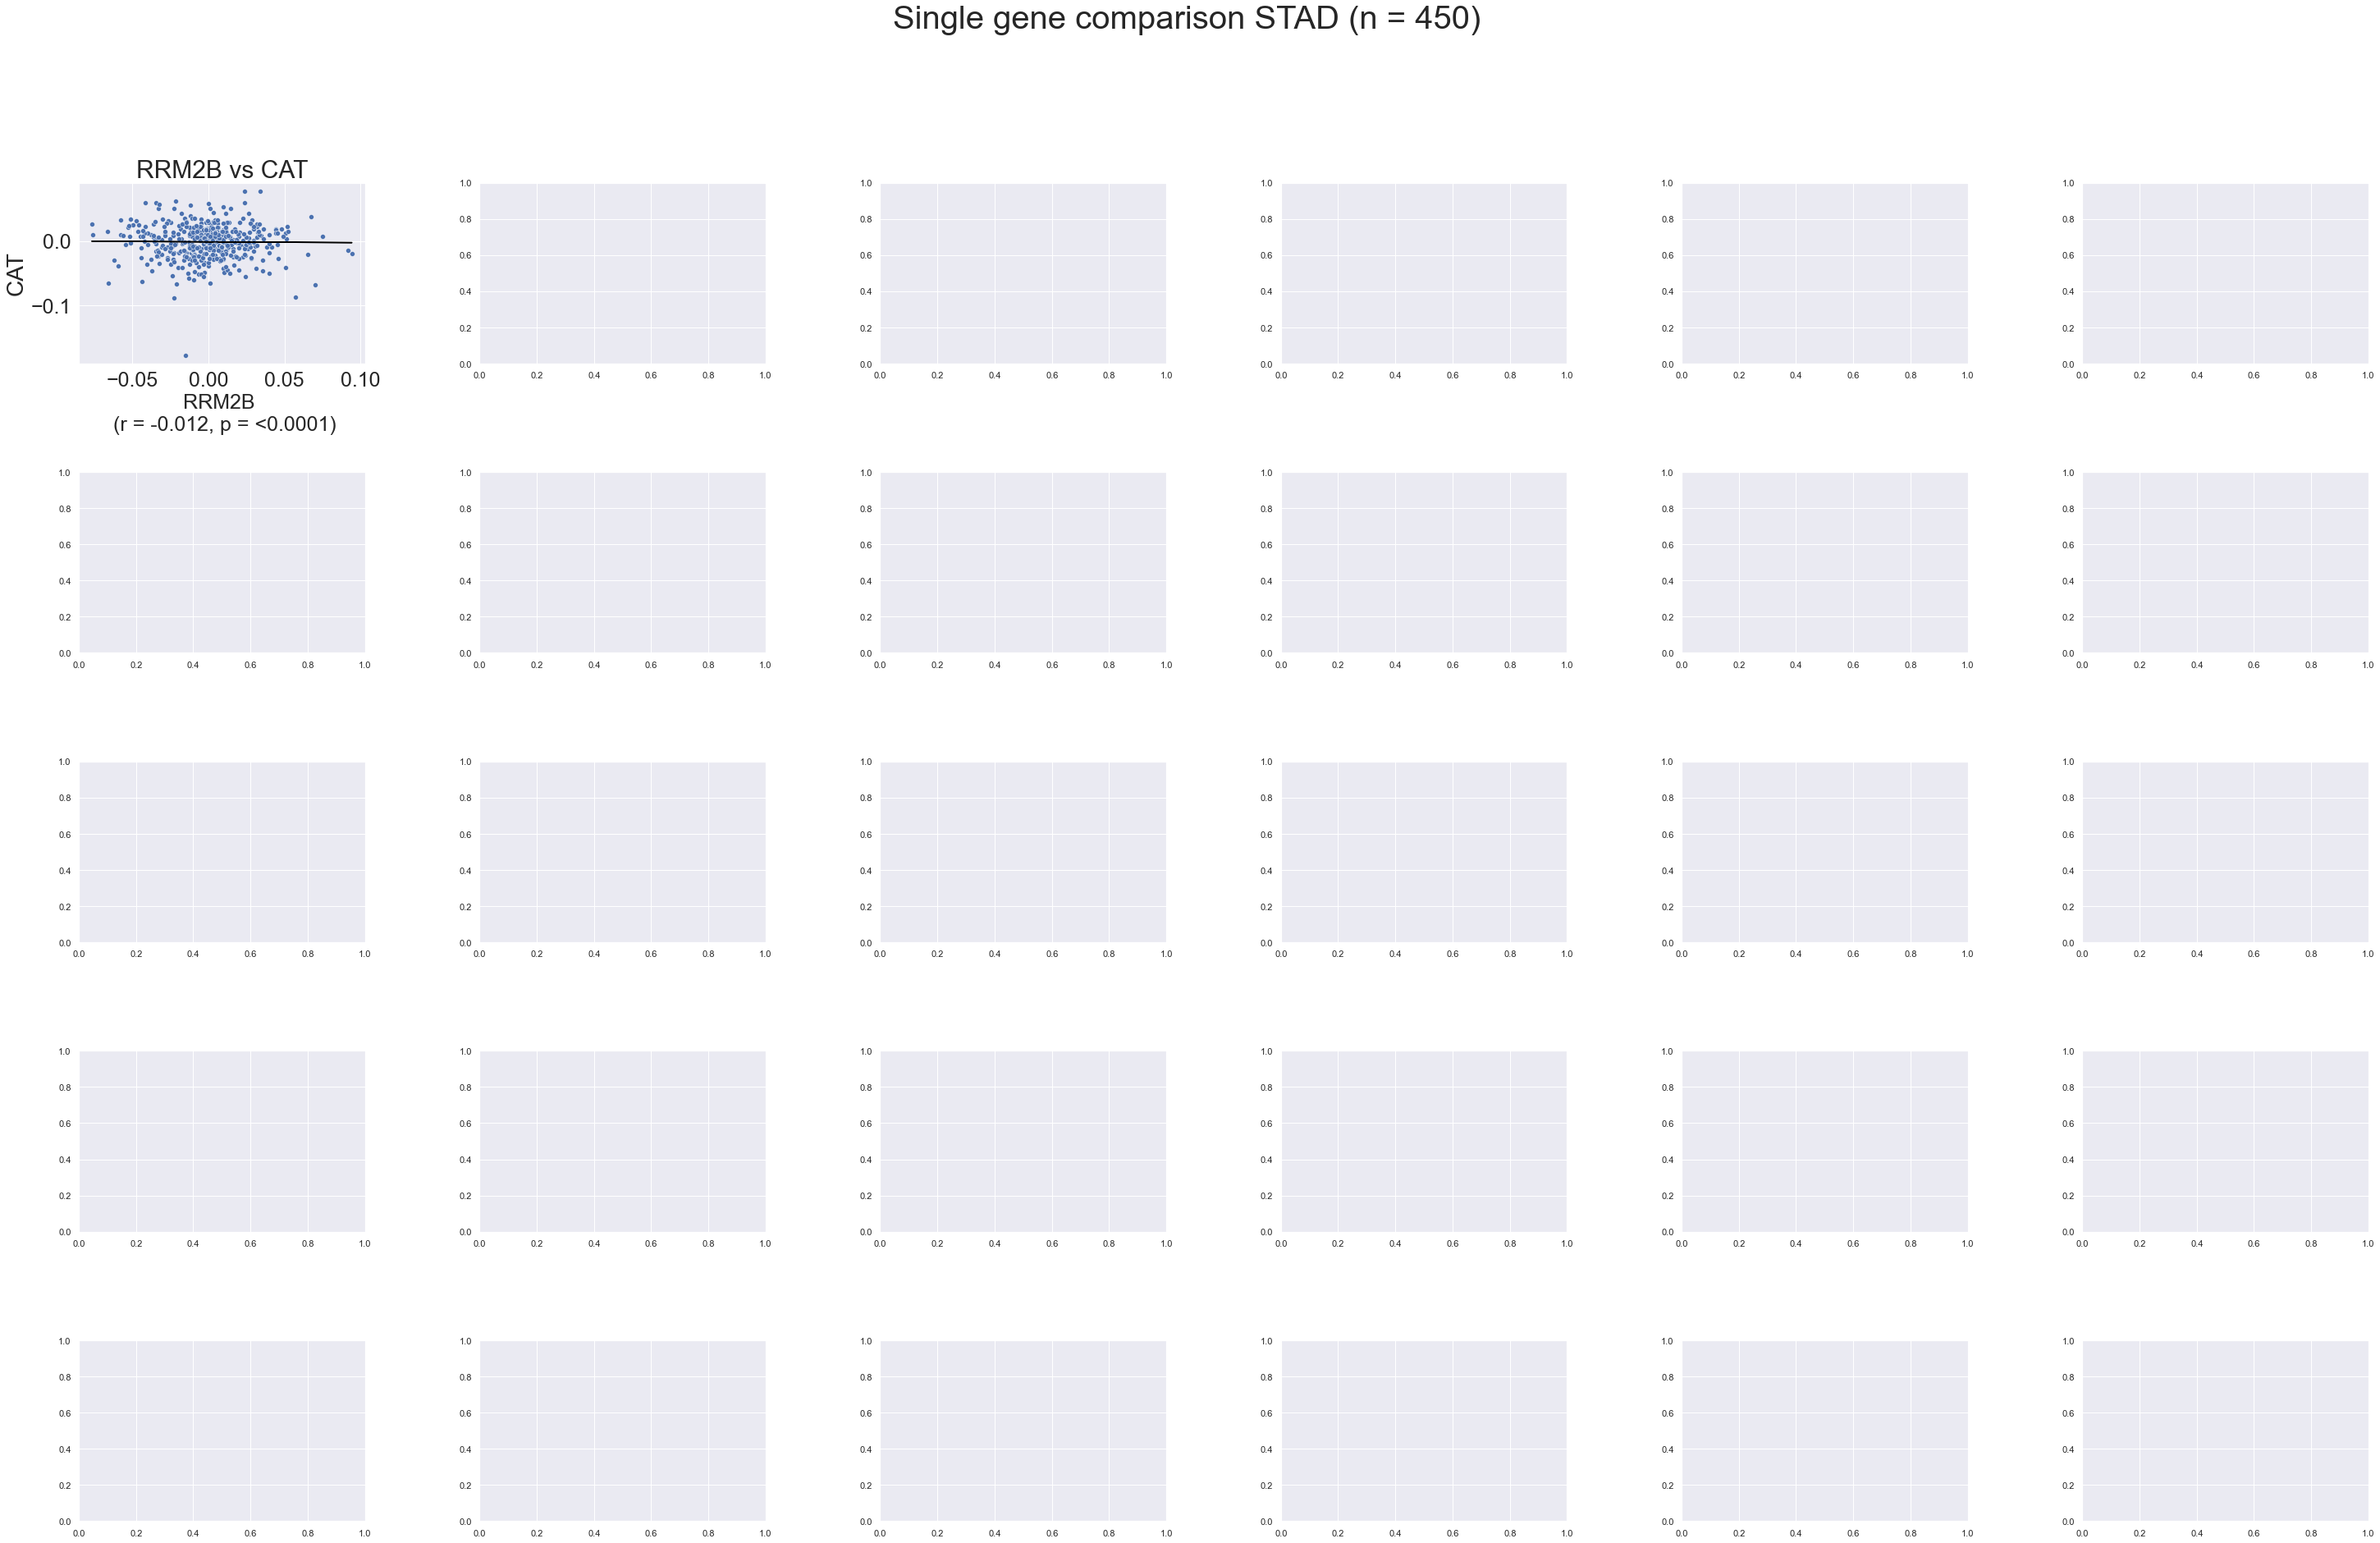

PRDX1
True
['TCGA-3M-AB46-01', 'TCGA-3M-AB47-01', 'TCGA-B7-5816-01', 'TCGA-B7-5818-01', 'TCGA-B7-A5TI-01', 'TCGA-B7-A5TJ-01', 'TCGA-B7-A5TK-01', 'TCGA-B7-A5TN-01', 'TCGA-BR-4187-01', 'TCGA-BR-4257-01', 'TCGA-BR-4280-01', 'TCGA-BR-4292-01', 'TCGA-BR-6452-01', 'TCGA-BR-6453-01', 'TCGA-BR-6453-11', 'TCGA-BR-6454-01', 'TCGA-BR-6454-11', 'TCGA-BR-6455-01', 'TCGA-BR-6456-01', 'TCGA-BR-6457-01', 'TCGA-BR-6457-11', 'TCGA-BR-6458-01', 'TCGA-BR-6458-11', 'TCGA-BR-6563-01', 'TCGA-BR-6564-01', 'TCGA-BR-6564-11', 'TCGA-BR-6565-01', 'TCGA-BR-6566-01', 'TCGA-BR-6705-01', 'TCGA-BR-6706-01', 'TCGA-BR-6707-01', 'TCGA-BR-6709-01', 'TCGA-BR-6801-01', 'TCGA-BR-6802-01', 'TCGA-BR-6802-11', 'TCGA-BR-6803-01', 'TCGA-BR-6852-01', 'TCGA-BR-6852-11', 'TCGA-BR-7196-01', 'TCGA-BR-7197-01', 'TCGA-BR-7703-01', 'TCGA-BR-7704-01', 'TCGA-BR-7704-11', 'TCGA-BR-7707-01', 'TCGA-BR-7715-01', 'TCGA-BR-7715-11', 'TCGA-BR-7716-01', 'TCGA-BR-7716-11', 'TCGA-BR-7717-01', 'TCGA-BR-7717-11', 'TCGA-BR-7722-01', 'TCGA-BR-7723-01', 

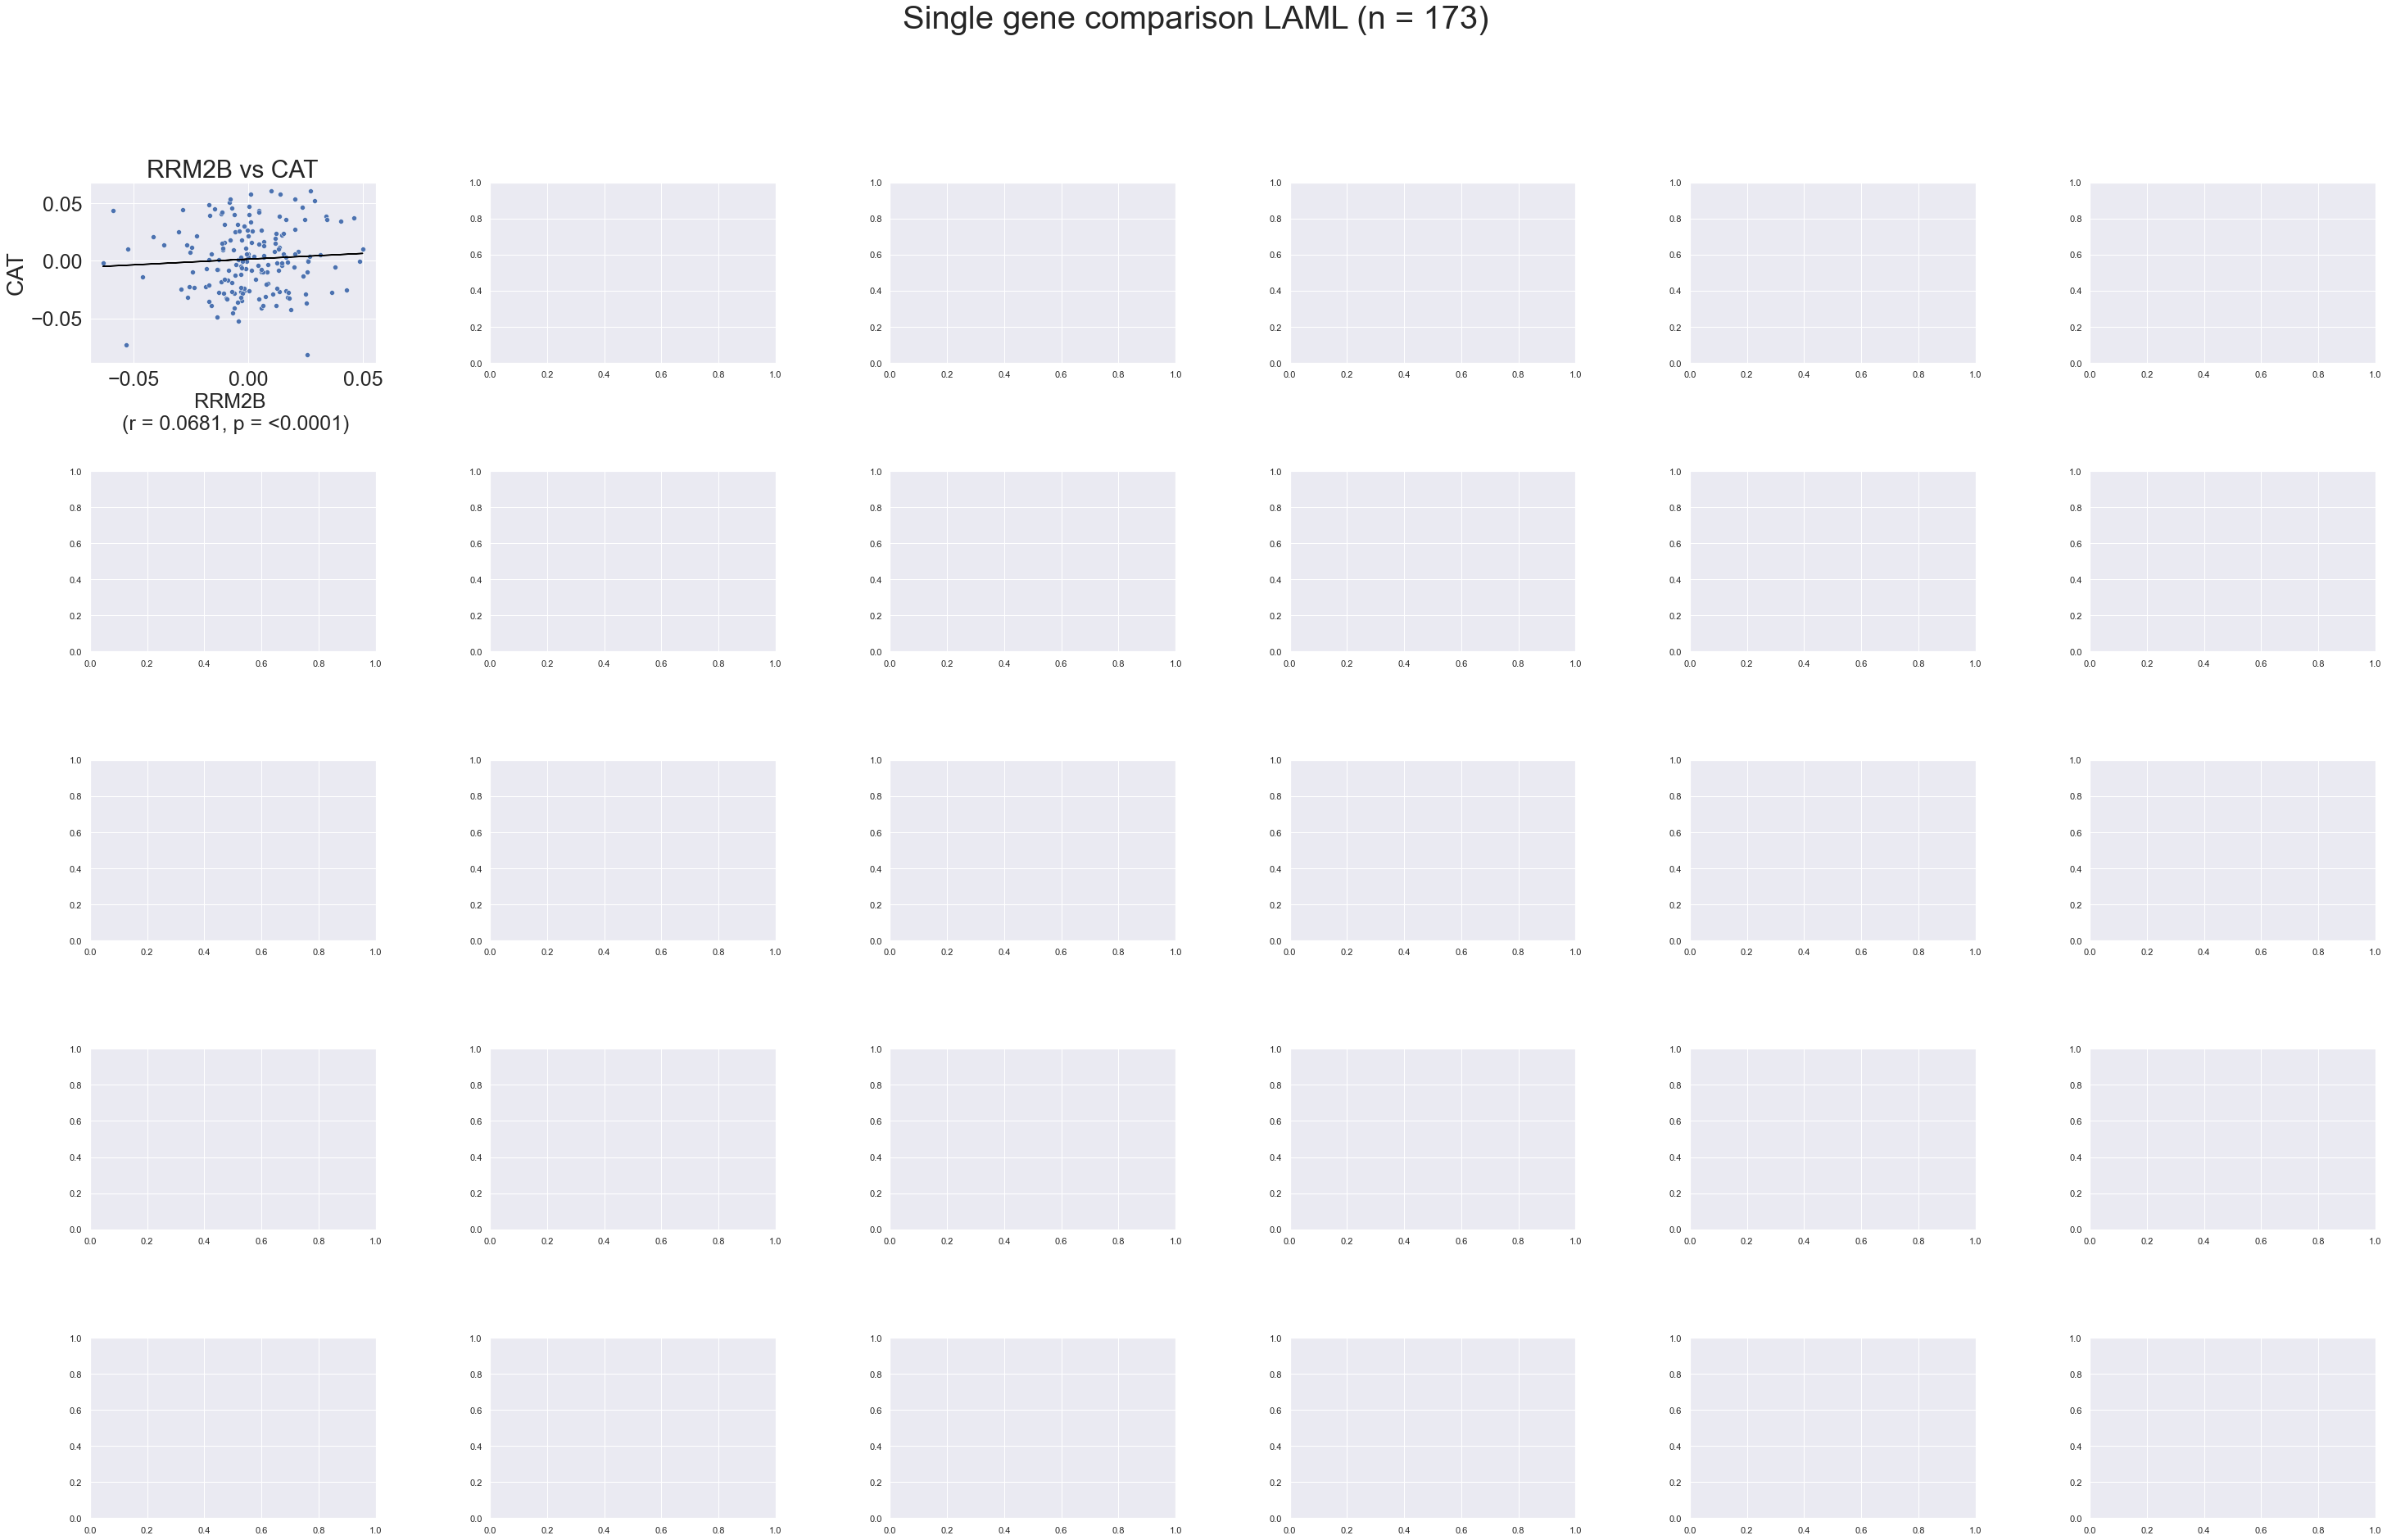

PRDX1
True
['TCGA-AB-2803-03', 'TCGA-AB-2805-03', 'TCGA-AB-2806-03', 'TCGA-AB-2807-03', 'TCGA-AB-2808-03', 'TCGA-AB-2810-03', 'TCGA-AB-2811-03', 'TCGA-AB-2812-03', 'TCGA-AB-2813-03', 'TCGA-AB-2814-03', 'TCGA-AB-2815-03', 'TCGA-AB-2816-03', 'TCGA-AB-2817-03', 'TCGA-AB-2818-03', 'TCGA-AB-2819-03', 'TCGA-AB-2820-03', 'TCGA-AB-2821-03', 'TCGA-AB-2822-03', 'TCGA-AB-2823-03', 'TCGA-AB-2824-03', 'TCGA-AB-2825-03', 'TCGA-AB-2826-03', 'TCGA-AB-2828-03', 'TCGA-AB-2830-03', 'TCGA-AB-2832-03', 'TCGA-AB-2833-03', 'TCGA-AB-2834-03', 'TCGA-AB-2835-03', 'TCGA-AB-2836-03', 'TCGA-AB-2837-03', 'TCGA-AB-2838-03', 'TCGA-AB-2839-03', 'TCGA-AB-2840-03', 'TCGA-AB-2841-03', 'TCGA-AB-2842-03', 'TCGA-AB-2843-03', 'TCGA-AB-2844-03', 'TCGA-AB-2845-03', 'TCGA-AB-2846-03', 'TCGA-AB-2847-03', 'TCGA-AB-2848-03', 'TCGA-AB-2849-03', 'TCGA-AB-2851-03', 'TCGA-AB-2853-03', 'TCGA-AB-2854-03', 'TCGA-AB-2855-03', 'TCGA-AB-2856-03', 'TCGA-AB-2857-03', 'TCGA-AB-2858-03', 'TCGA-AB-2859-03', 'TCGA-AB-2860-03', 'TCGA-AB-2861-03', 

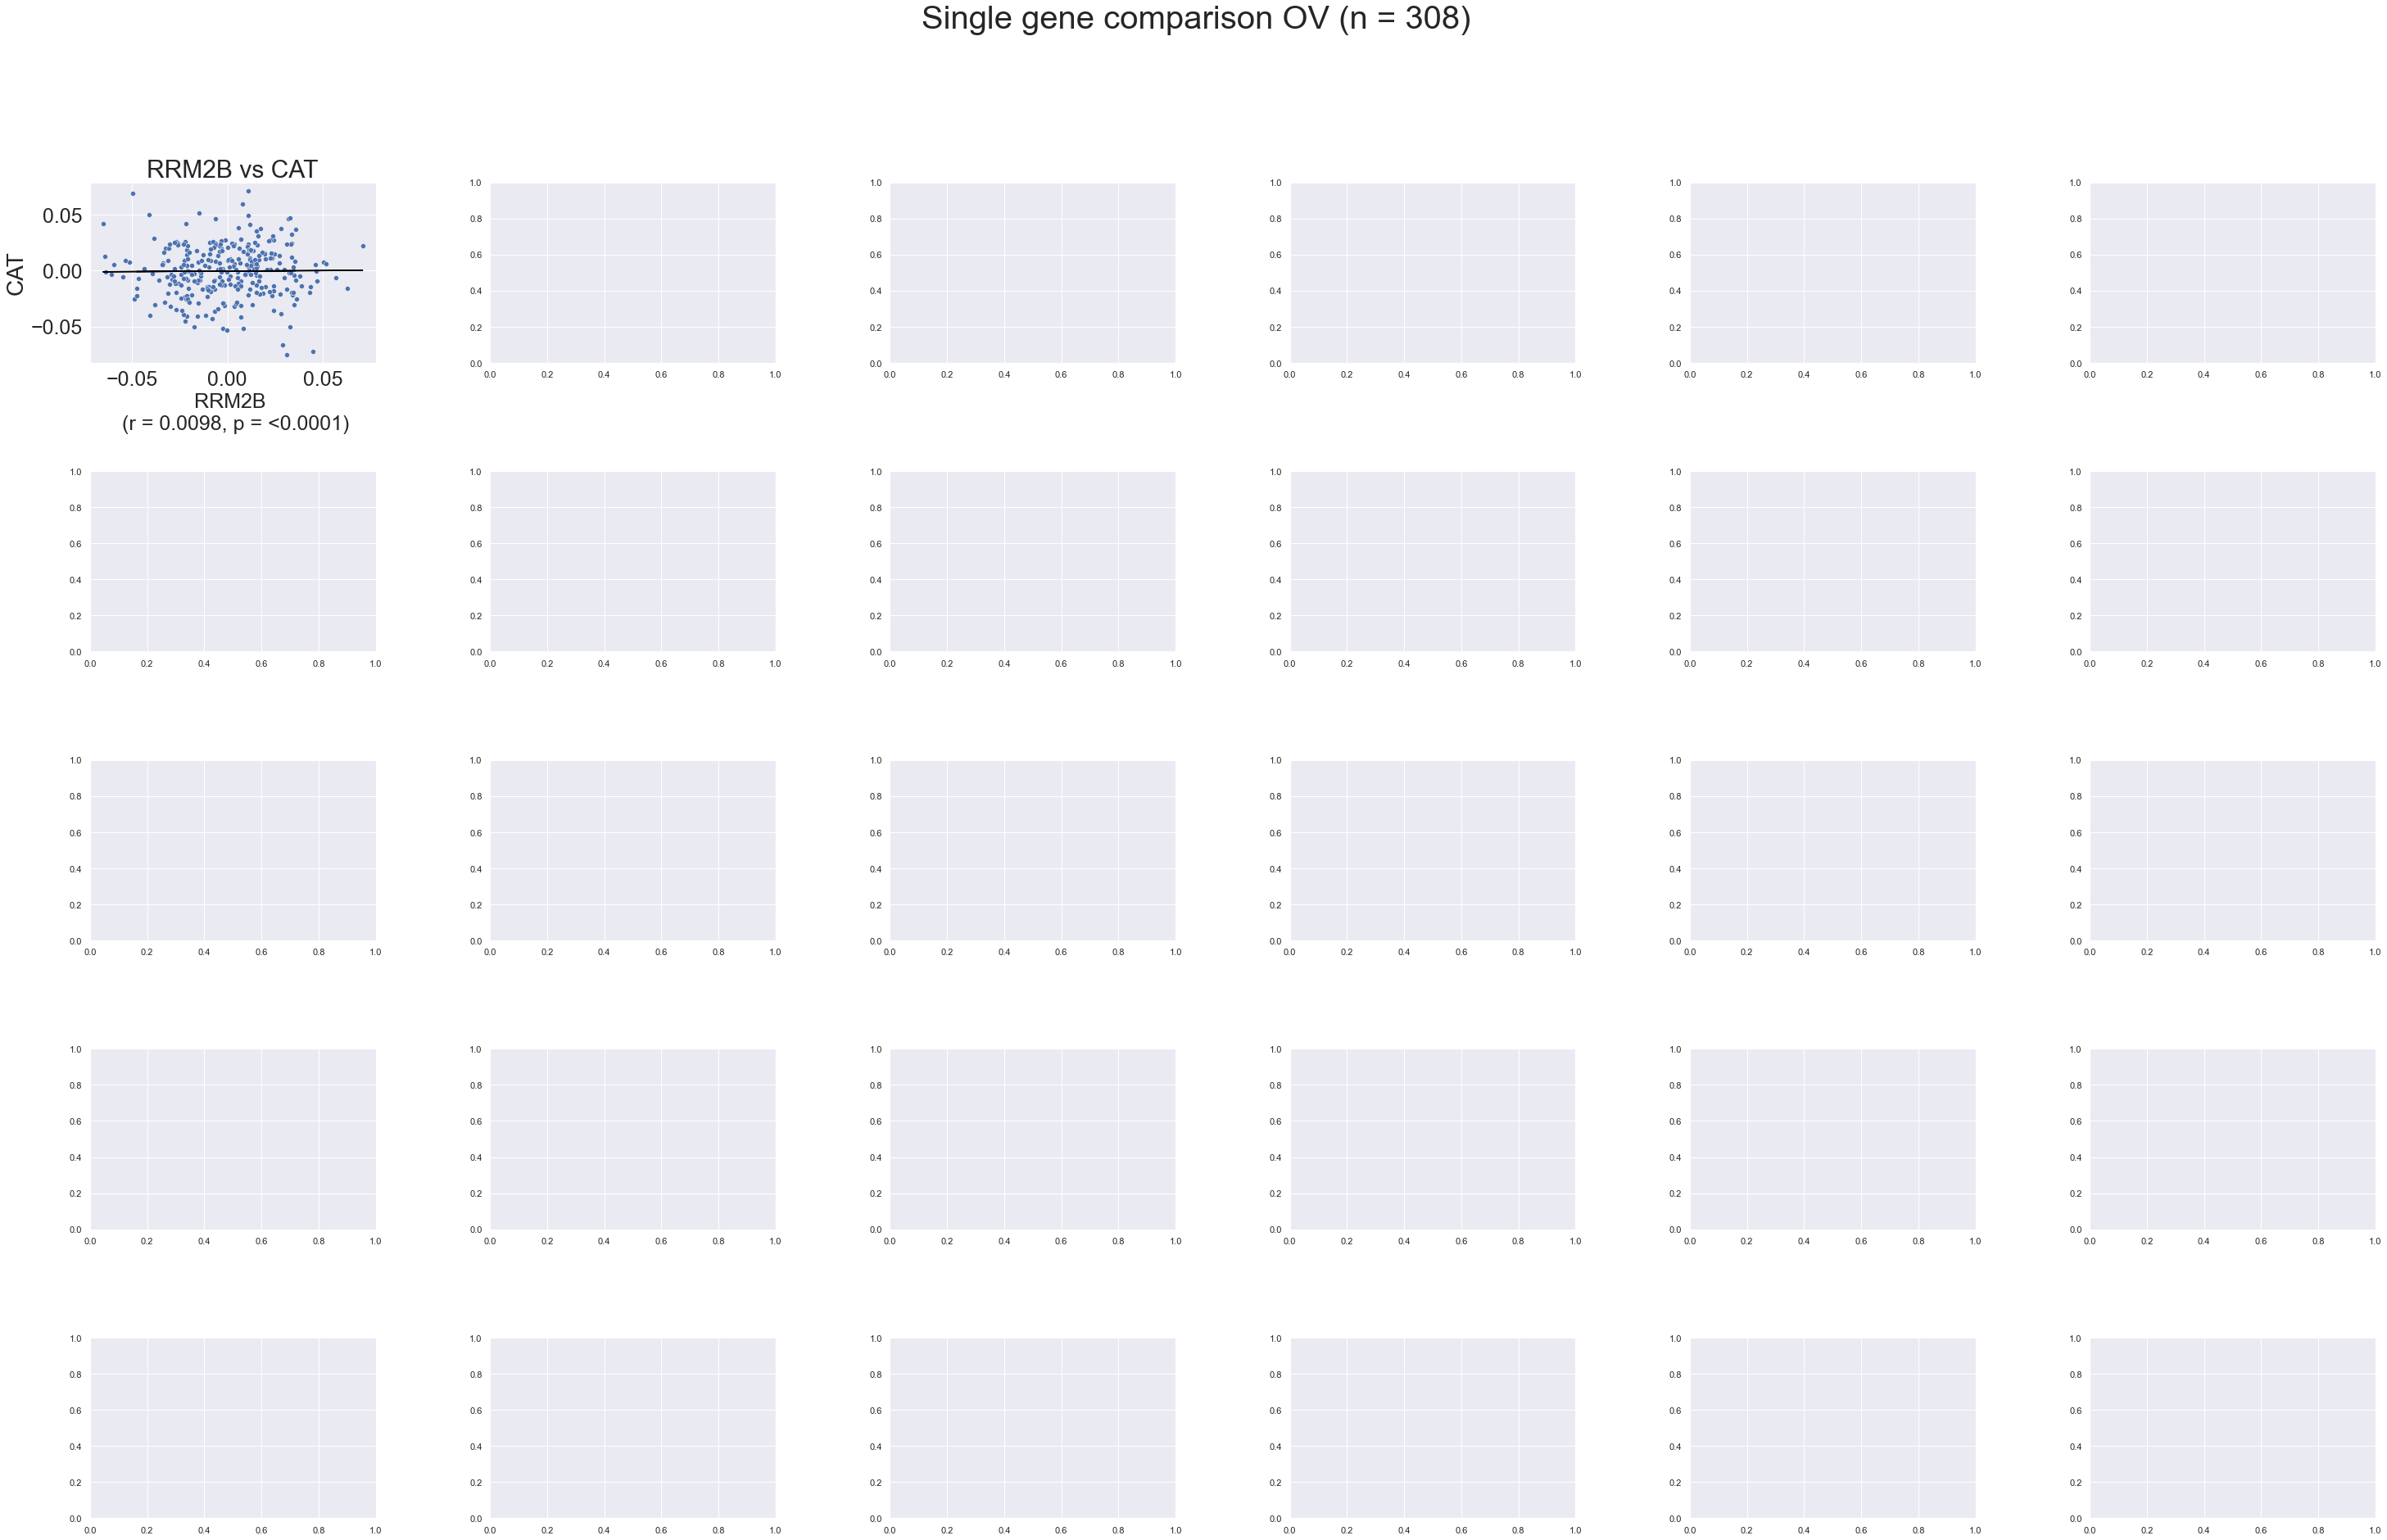

PRDX1
True
['TCGA-04-1348-01', 'TCGA-04-1357-01', 'TCGA-04-1362-01', 'TCGA-04-1364-01', 'TCGA-04-1365-01', 'TCGA-04-1514-01', 'TCGA-04-1519-01', 'TCGA-09-0364-01', 'TCGA-09-0366-01', 'TCGA-09-0367-01', 'TCGA-09-0369-01', 'TCGA-09-1659-01', 'TCGA-09-1662-01', 'TCGA-09-1666-01', 'TCGA-09-1667-01', 'TCGA-09-1668-01', 'TCGA-09-1669-01', 'TCGA-09-1670-01', 'TCGA-09-1673-01', 'TCGA-09-1674-01', 'TCGA-09-2044-01', 'TCGA-09-2045-01', 'TCGA-09-2048-01', 'TCGA-09-2051-01', 'TCGA-09-2054-01', 'TCGA-10-0928-01', 'TCGA-10-0936-01', 'TCGA-13-0730-01', 'TCGA-13-0799-01', 'TCGA-13-0800-01', 'TCGA-13-0801-01', 'TCGA-13-0890-01', 'TCGA-13-0893-01', 'TCGA-13-0897-01', 'TCGA-13-0899-01', 'TCGA-13-0913-01', 'TCGA-13-0916-01', 'TCGA-13-0920-01', 'TCGA-13-0924-01', 'TCGA-13-1403-01', 'TCGA-13-1405-01', 'TCGA-13-1410-01', 'TCGA-13-1411-01', 'TCGA-13-1481-01', 'TCGA-13-1489-02', 'TCGA-13-1497-01', 'TCGA-13-1498-01', 'TCGA-13-1505-01', 'TCGA-13-1506-01', 'TCGA-13-1507-01', 'TCGA-13-1511-01', 'TCGA-13-1512-01', 

In [26]:
# single gene screen

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['NRF2 v3'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

r_all =[]
p_all = []
databases = ['DBLC', 'SKCM', 'HNSC', 'PRAD', 'PAAD', 'SARC', 'BRCA', 'UCS', 'ESCA', 'STAD', 'LAML', 'OV' ] # , , 'PANCAN'

genes =['CAT', 'PRDX1', 'PRDX6', 'GPX2', 'GSR', 
        'SLC6A9', 'TXN', 'SRXN1', 'G6PD', 'IDH1', 
        'ME1', 'PGD', 'AKR1B10', 'AKR1C1', 'ALDH3A1', 
        'CBR1', 'EPHX1', 'NQO1', 'NQO2', 'PTGR1', 
        'UGT1A6', 'GSTA1', 'GSTA2', 'GSTA3', 'GSTA4', 
        'GSTA5', 'GSTM1', 'GSTM2', 'GSTM3', 'GSTP1' ]

for db in databases:

    # load data
    df = data[data["ptype"] == db]
    df = df.T
    df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)

    # define subplot grid
    fig, axs = plt.subplots(5, 6, figsize=(50, 30))
    plt.subplots_adjust(hspace=0.6, wspace = 0.4)
    fig.suptitle('Single gene comparison ' + db + " (n = " + str(df.shape[1]) + ")",fontsize = 40)

    rtemp = [db]
    ptemp = [db]
    print(db)
    
    for g, ax in zip(genes, axs.ravel()):
        print(g)
        data_new = process_data_gene_comparisons(df, targets, gene_set, pheno_filtered=None)
        r,p=analyse(data_new, fig, "RRM2B vs " + g , ax, 'RRM2B vs genes' + db + '.png', x_label = "RRM2B", y_label = g, x_target = 'RRM2B', y_target = g )
        rtemp.append(r)
        ptemp.append(p)

    r_all.append(rtemp)
    p_all.append(ptemp)
    
print("done")

df_r = pd.DataFrame(r_all, columns = ["database"] + genes)
df_p = pd.DataFrame(p_all, columns = ["database"] + genes)
df_r.to_csv("r values.csv")
df_p.to_csv("p values.csv")
